In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf
import pyspark.sql.functions as F
from astropy.time import Time

from fink_filters.classification import extract_fink_classification

from fink_science.fast_transient_rate.processor import (
    fast_transient_rate,
    fast_transient_module,
)
from fink_science.fast_transient_rate import rate_module_output_schema

/opt/spark-3/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)
/opt/spark-3/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [2]:
def fink_classification(spark_df):
    return spark_df.withColumn(
        "fink_class",
        extract_fink_classification(
            spark_df.cdsxmatch,
            spark_df.roid,
            spark_df.mulens,
            spark_df.snn_snia_vs_nonia,
            spark_df.snn_sn_vs_all,
            spark_df.rf_snia_vs_nonia,
            spark_df.candidate.ndethist,
            spark_df.candidate.drb,
            spark_df.candidate.classtar,
            spark_df.candidate.jd,
            spark_df.candidate.jdstarthist,
            spark_df.rf_kn_vs_nonkn,
            spark_df.tracklet,
        ),
    )

In [3]:
def compute_and_save_ftmodule(path_data):
    df = (
        spark.read
        .option("basePath", "/user/julien.peloton/archive/science/")
        .format("parquet")
        .load(path_data)
    )

    df = fink_classification(df)
    df = fast_transient_module(df, 100)
    requested_cols = [
        "objectId",
        "candid",
        "fink_class",
        "cast(candidate.ra as double)",
        "cast(candidate.dec as double)",
        "cast(candidate.magpsf as double)",
        "cast(candidate.sigmapsf as double)",
        "cast(candidate.diffmaglim as double)",
        "cast(candidate.fid as integer)",
        "cast(candidate.jd as double)",
        "cast(candidate.jdstarthist as double)",
        "cast(candidate.distnr as double)",
        "cast(candidate.distpsnr1 as double)",
        "cast(candidate.drb as double)",
        "cast(candidate.rb as double)",
        "cast(nalerthist as integer)",
        "year",
        "month",
    ] + list(rate_module_output_schema.keys())

    df.selectExpr(requested_cols).write.mode("append").partitionBy(
        "year", "month"
    ).parquet("fast_transient_module_data/")

### Run the fast transient module over all the Fink data and save it on hdfs

In [4]:
path_data = [
    "/user/julien.peloton/archive/science/year=2019",
    "/user/julien.peloton/archive/science/year=2020",
    "/user/julien.peloton/archive/science/year=2021",
]
compute_and_save_ftmodule(path_data)

In [5]:
path_data = [
    "/user/julien.peloton/archive/science/year=2022",
    "/user/julien.peloton/archive/science/year=2023",
]
compute_and_save_ftmodule(path_data)

Output Size : 13.2 GB

### Analysis

In [2]:
df = (
    spark.read
    .option("basePath", "/user/roman.le-montagner/")
    .format("parquet")
    .load("fast_transient_module_data")
    .cache()
)

In [14]:
df.printSchema()

root
 |-- objectId: string (nullable = true)
 |-- candid: long (nullable = true)
 |-- fink_class: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- magpsf: double (nullable = true)
 |-- sigmapsf: double (nullable = true)
 |-- diffmaglim: double (nullable = true)
 |-- fid: integer (nullable = true)
 |-- jd: double (nullable = true)
 |-- jdstarthist: double (nullable = true)
 |-- distnr: double (nullable = true)
 |-- distpsnr1: double (nullable = true)
 |-- drb: double (nullable = true)
 |-- nalerthist: integer (nullable = true)
 |-- jd_first_real_det: double (nullable = true)
 |-- jdstarthist_dt: double (nullable = true)
 |-- mag_rate: double (nullable = true)
 |-- sigma_rate: double (nullable = true)
 |-- lower_rate: double (nullable = true)
 |-- upper_rate: double (nullable = true)
 |-- delta_time: double (nullable = true)
 |-- from_upper: boolean (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = tru

In [5]:
df.groupBy("fink_class").count().orderBy("count", ascending=False).show(300)

+--------------------+--------+
|          fink_class|   count|
+--------------------+--------+
|             Unknown|59037700|
|    Solar System MPC|15759160|
|                  V*| 7404401|
|               RRLyr| 6223806|
|       Candidate_EB*| 5429979|
|                 EB*| 3800466|
|                 QSO| 2513208|
|                Star| 2025969|
|       Candidate_LP*| 1986151|
|                Mira| 1641072|
|       EB*_Candidate| 1509089|
|                LPV*| 1231509|
|     Candidate_RRLyr|  751057|
|              PulsV*|  552584|
|       LP*_Candidate|  537499|
|           Seyfert_1|  535969|
|        SN candidate|  522094|
|Solar System cand...|  393476|
|                  C*|  314014|
|                 YSO|  212318|
|     RRLyr_Candidate|  211709|
|       Candidate_YSO|  199616|
|               BLLac|  172383|
|                Blue|  161128|
|           CataclyV*|  151649|
|            deltaCep|  113917|
|            Tracklet|  112927|
|                 Em*|  110887|
|       

In [3]:
selected_cols = [
    "objectId",
    "fink_class",
    "magpsf",
    "sigmapsf",
    "fid",
    "diffmaglim",
    "jd",
    "mag_rate",
    "sigma_rate",
    "lower_rate",
    "upper_rate",
    "from_upper",
]

In [7]:
some_variable_star = ["RRLyr", "Mira", "PulsV*", "EB*", "YSO", "deltaCep"]

local_vs = (
    df.filter(df.fink_class.isin(some_variable_star)).select(selected_cols).toPandas()
)

In [8]:
local_vs

,objectId,fink_class,magpsf,sigmapsf,fid,diffmaglim,jd,mag_rate,sigma_rate,lower_rate,upper_rate,from_upper
0,ZTF18abtmoxu,EB*,17.662386,0.081151,1,19.869539,2.459969e+06,-0.004918,0.008619,-0.019820,0.010888,False
1,ZTF18abspnmv,RRLyr,18.562780,0.135149,1,19.707409,2.459969e+06,-0.033575,0.015408,-0.060599,-0.011175,False
2,ZTF17aabukwo,EB*,17.861448,0.048640,1,19.953129,2.459969e+06,-0.021817,0.006530,-0.033746,-0.012305,False
3,ZTF17aabcjkw,EB*,18.753481,0.137195,1,20.145414,2.459969e+06,-0.004836,0.069581,-0.135087,0.072017,True
4,ZTF18adnpdim,EB*,18.583513,0.080696,1,20.087093,2.459969e+06,0.013608,0.009165,-0.001522,0.027824,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12544158,ZTF18abccnkb,EB*,17.599257,0.079423,2,18.545355,2.460022e+06,-2.806314,1.070565,-4.820402,-1.835895,True
12544159,ZTF18abebuuf,EB*,18.324001,0.164355,2,18.541004,2.460022e+06,-2.061511,1.003274,-4.244012,-1.022567,True
12544160,ZTF18abcoyxj,EB*,16.138521,0.071125,2,18.762545,2.459306e+06,-0.702136,0.214145,-1.093723,-0.489719,True
12544161,ZTF19aaafpfi,RRLyr,15.619508,0.016759,2,18.951569,2.459224e+06,-0.599592,0.223418,-1.120057,-0.410629,True


### Population Study

In [33]:
def plot_hist_class(df, min_log, max_log, nbins):
    fig = plt.figure(figsize=(15, 8))

    bins = np.logspace(min_log, max_log, nbins)

    round_float = 6

    unique_class = df["fink_class"].unique()
    for f_class, color in zip(
        unique_class, plt.cm.viridis(np.linspace(0, 1, len(unique_class)))
    ):
        data = (
            df[df["fink_class"] == f_class][["objectId", "mag_rate"]]
            .groupby("objectId")
            .mean()["mag_rate"]
        )

        print(
            "class: ",
            f_class,
            ", min=",
            round(data.min(), round_float),
            ", max=",
            round(data.max(), round_float),
            ", mean=",
            round(np.mean(data), round_float),
        )

        p = plt.hist(data, bins=bins, label=f_class, histtype="step", color=color)

        plt.axvline(np.median(data), linewidth=4, color=color)

    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("magnitude_rate (mag/day)")
    plt.legend()
    plt.show()

In [30]:
plot_hist_class(local_vs, -3, 3, 100)

NameError: name 'local_vs' is not defined

In [4]:
some_class = ["Early SN Ia candidate", "SN", "QSO", "V*"]

local_class = df.filter(df.fink_class.isin(some_class)).select(selected_cols).toPandas()

In [31]:
clean_rate = local_class[
    (local_class["lower_rate"] > 0) | (local_class["upper_rate"] < 0)
]
fading_rate = clean_rate[clean_rate["mag_rate"] > 0]
rising_rate = clean_rate[clean_rate["mag_rate"] < 0]

class:  V* , min= 0.001619 , max= 1306.994709 , mean= 0.812094
class:  QSO , min= 0.004394 , max= 183.399635 , mean= 0.232156
class:  SN , min= 0.003952 , max= 100.614603 , mean= 0.510605
class:  Early SN Ia candidate , min= 0.007944 , max= 0.11846 , mean= 0.029917


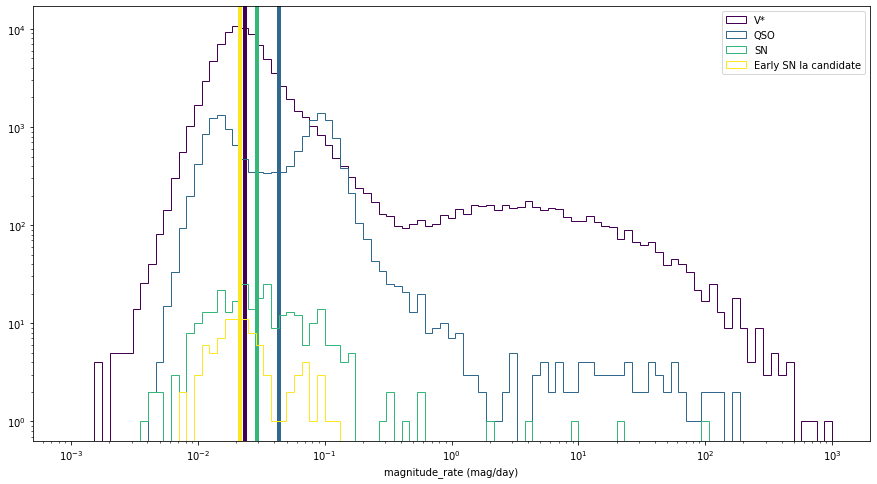

In [34]:
plot_hist_class(fading_rate, -3, 3, 100)

### Some lightcurves with rate

In [41]:
nalert = clean_rate.groupby("objectId").count().reset_index()
sample_object = nalert[nalert["fink_class"] > 10]["objectId"].sample(10)

In [22]:
def plot_magnitude_and_rate(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)

    fig.suptitle(
        df["objectId"].values[0] + " " + df["fink_class"].values[0], y=0.99, fontsize=25
    )

    for _filt, label_filt in [(1, "g band"), (2, "r band")]:
        tmp_filt = df[df["fid"] == _filt]
        time = Time(tmp_filt["jd"], format="jd")

        ax1.errorbar(
            tmp_filt["jd"],
            tmp_filt["magpsf"],
            tmp_filt["sigmapsf"],
            label=label_filt,
            fmt="o",
            markersize=15,
            linestyle="",
        )

        ax2.errorbar(
            tmp_filt["jd"],
            tmp_filt["mag_rate"],
            [
                tmp_filt["mag_rate"] - tmp_filt["lower_rate"],
                tmp_filt["upper_rate"] - tmp_filt["mag_rate"],
            ],
            label=label_filt,
            fmt="o",
            markersize=15,
            linestyle="",
        )

    # plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # time = Time(df["jd"], format="jd")
    # ax2.set_xticklabels(time.iso, rotation=45, ha='right')

    ax1.set_ylabel("magnitude", fontsize=25)
    ax1.invert_yaxis()
    ax1.tick_params(axis="x", which="major", labelsize=30)
    ax1.tick_params(axis="y", which="major", labelsize=25)

    ax2.set_ylabel("magnitude rate (mag/day)", fontsize=25)
    ax2.invert_yaxis()
    ax2.tick_params(axis="x", which="major", labelsize=30)
    ax2.tick_params(axis="y", which="major", labelsize=25)

    plt.legend(prop={"size": 30})
    plt.tight_layout()
    plt.show()

In [43]:
clean_rate[clean_rate["objectId"] == "ZTF19adawrly"]

,objectId,fink_class,magpsf,sigmapsf,fid,diffmaglim,jd,mag_rate,sigma_rate,lower_rate,upper_rate,from_upper
7332,ZTF19adawrly,QSO,19.024944,0.141705,2,20.230944,2.459969e+06,-0.171037,0.113616,-0.372815,-0.053140,True
147954,ZTF19adawrly,QSO,19.648247,0.170190,1,20.231630,2.459678e+06,-0.300845,0.171480,-0.687062,-0.148229,True
196192,ZTF19adawrly,QSO,18.705046,0.116210,2,19.902294,2.459966e+06,-0.094888,0.029483,-0.154135,-0.063085,True
220705,ZTF19adawrly,QSO,18.887638,0.100156,2,20.239702,2.459973e+06,-0.115983,0.069871,-0.258103,-0.050994,True
260906,ZTF19adawrly,QSO,19.168182,0.111890,1,20.434223,2.459973e+06,0.019371,0.011317,0.000065,0.037779,False
547155,ZTF19adawrly,QSO,19.235226,0.111607,2,20.598000,2.460045e+06,0.017168,0.007295,0.004459,0.029248,False
592614,ZTF19adawrly,QSO,18.688000,0.167210,2,19.349428,2.459903e+06,-0.102447,0.071347,-0.216330,-0.032091,True
613092,ZTF19adawrly,QSO,18.913082,0.145619,2,19.796799,2.459971e+06,-0.130968,0.084003,-0.267366,-0.051252,True
902667,ZTF19adawrly,QSO,19.221861,0.172147,2,19.651285,2.459985e+06,-0.053438,0.038213,-0.122572,-0.015504,True
996025,ZTF19adawrly,QSO,19.501808,0.116967,1,20.441219,2.459691e+06,-0.117536,0.057380,-0.220383,-0.061608,True


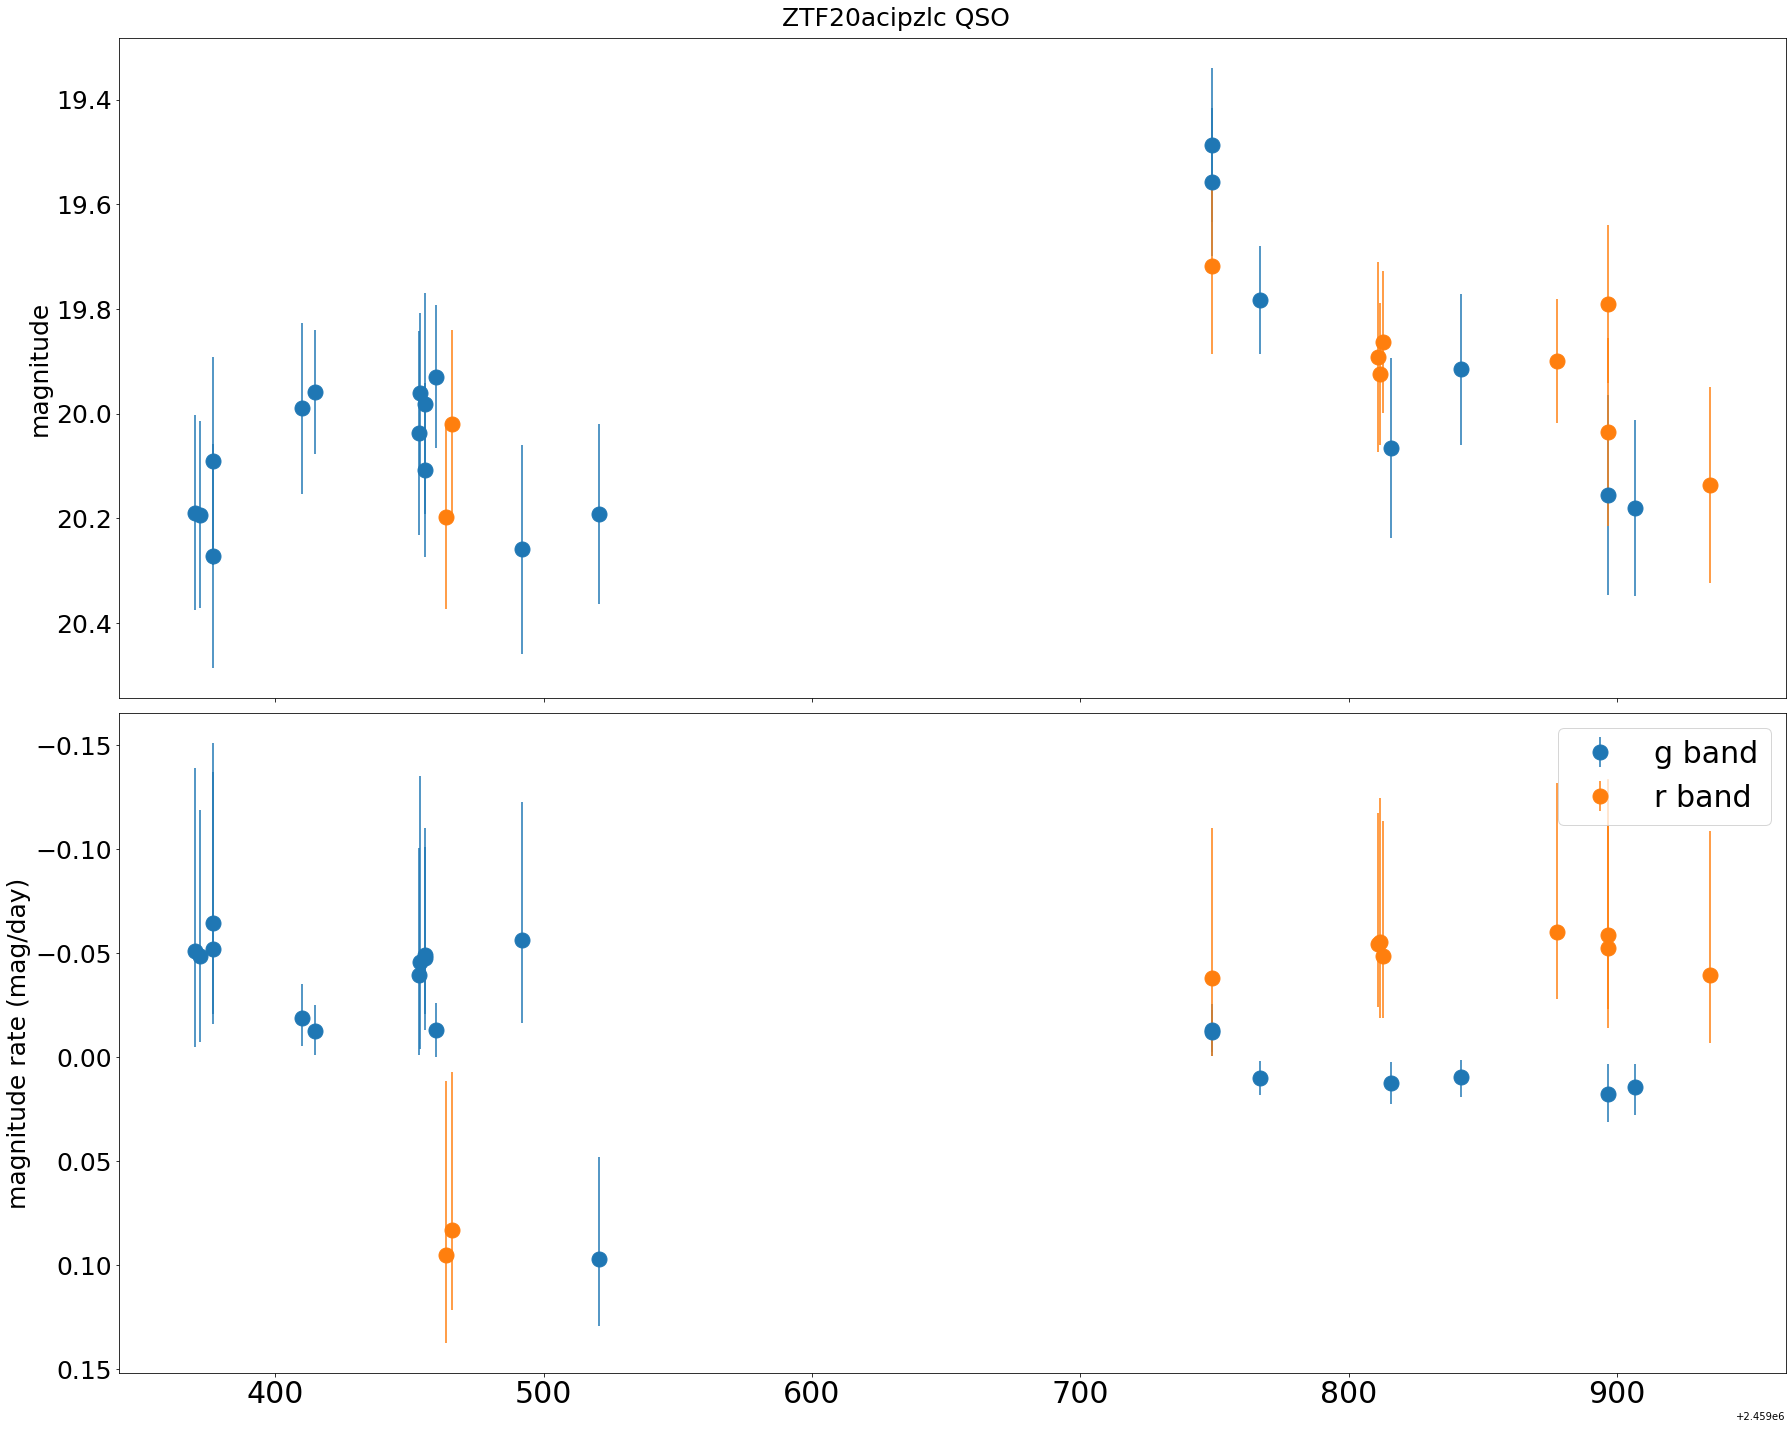

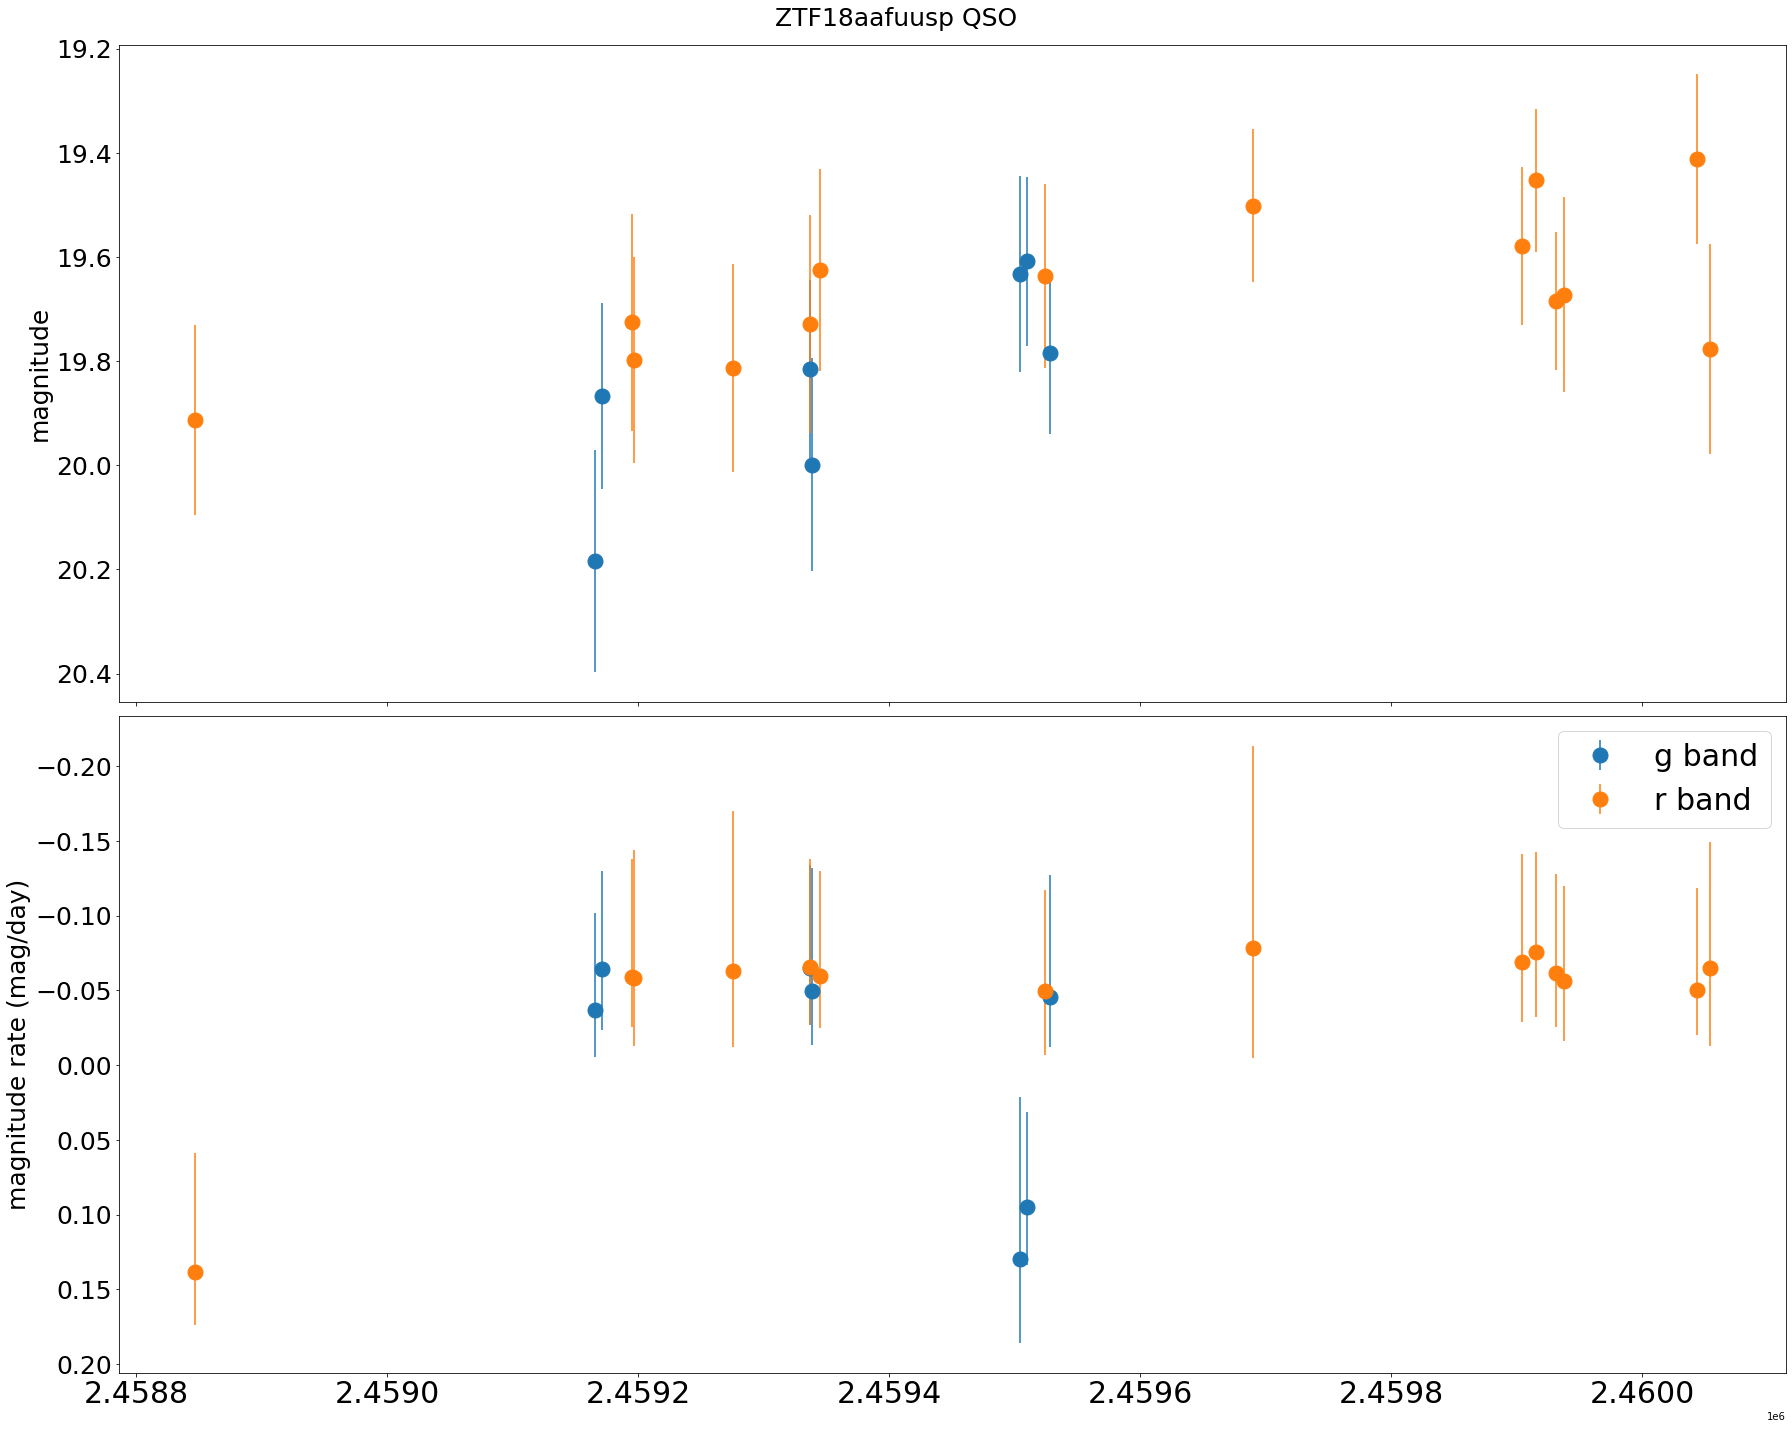

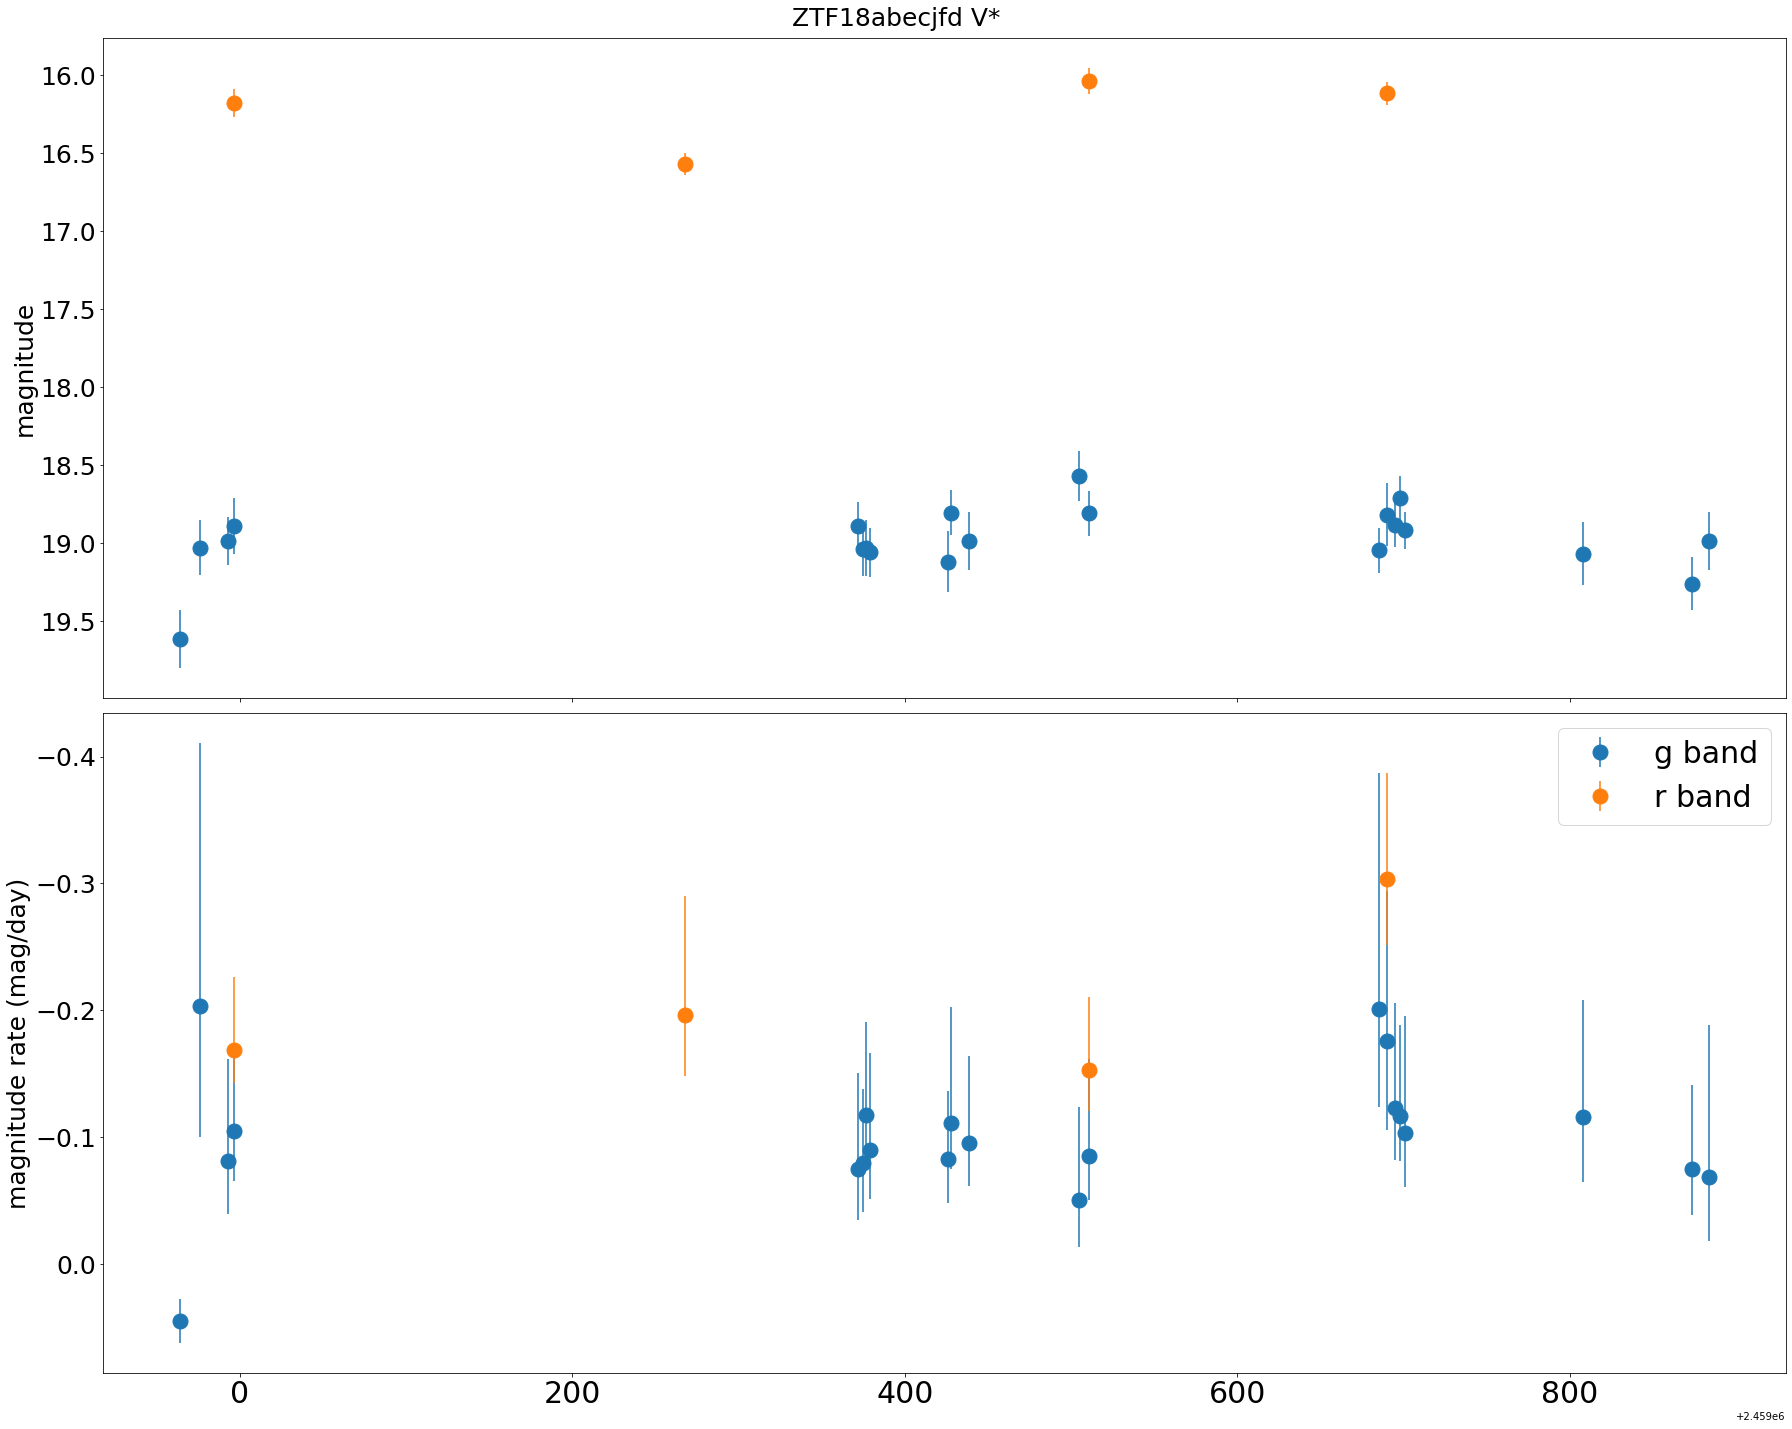

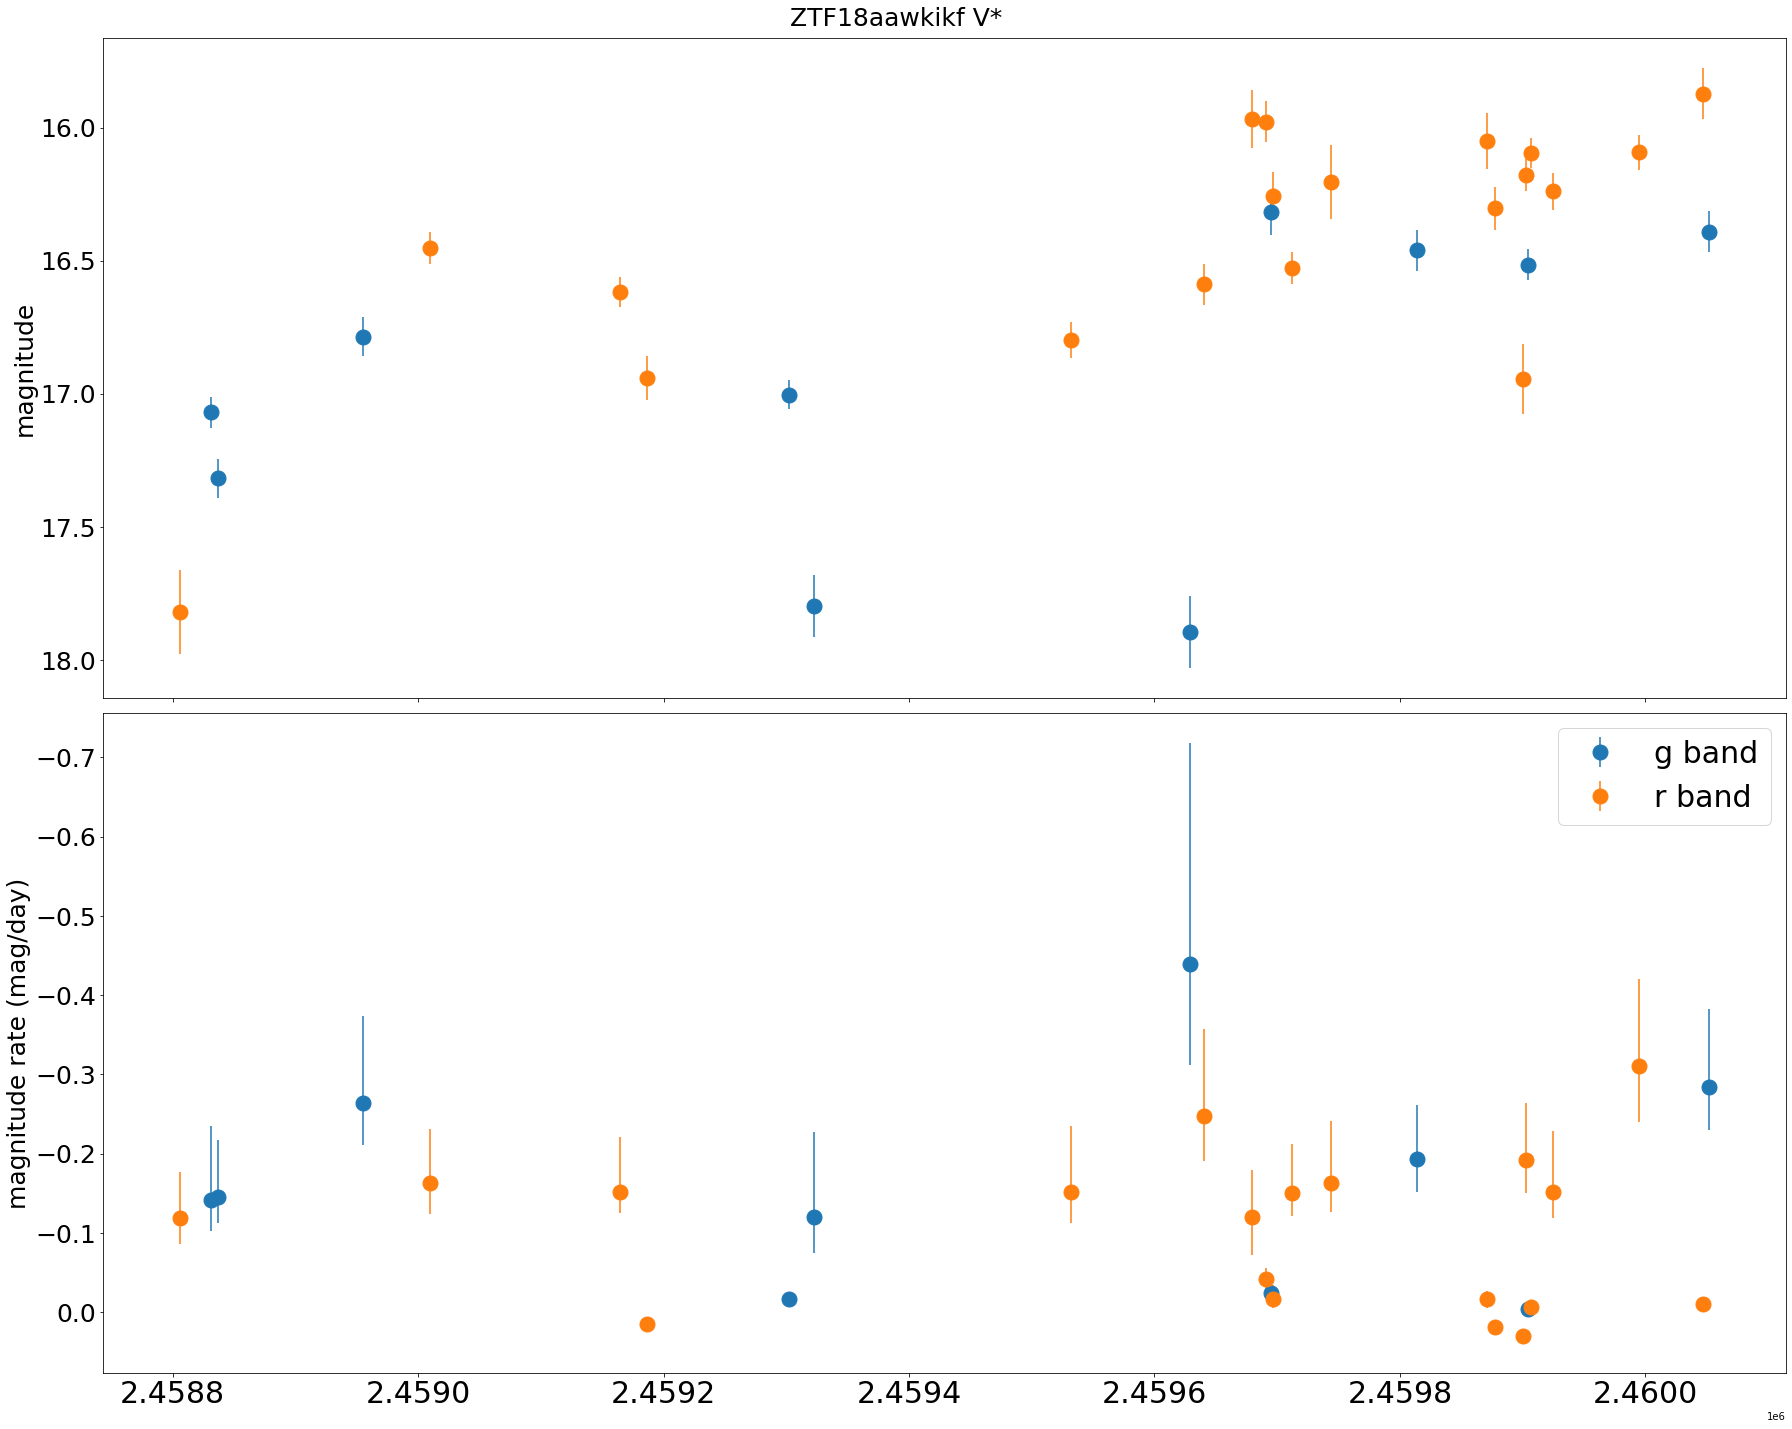

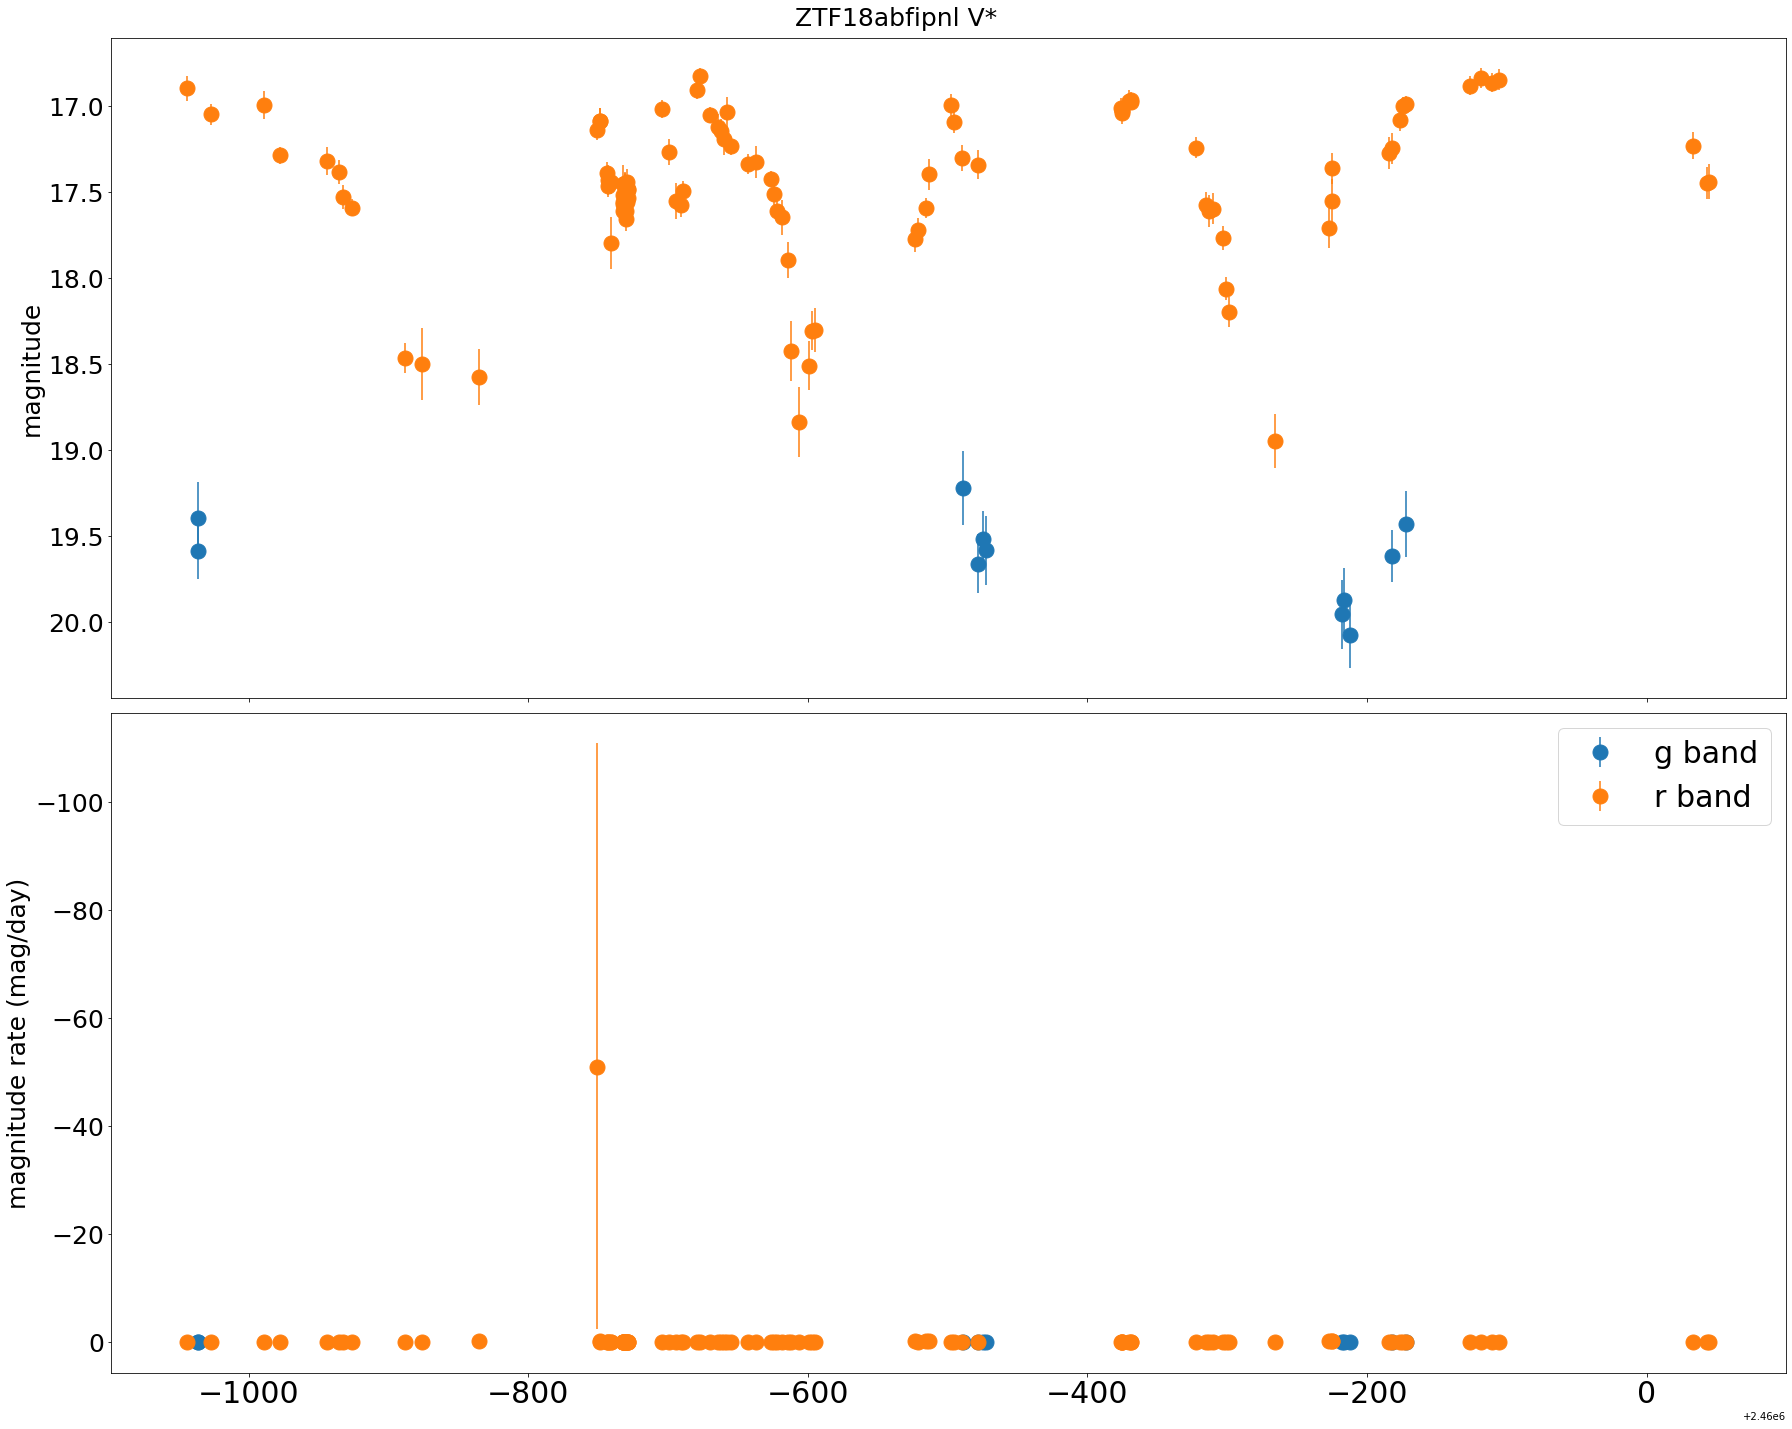

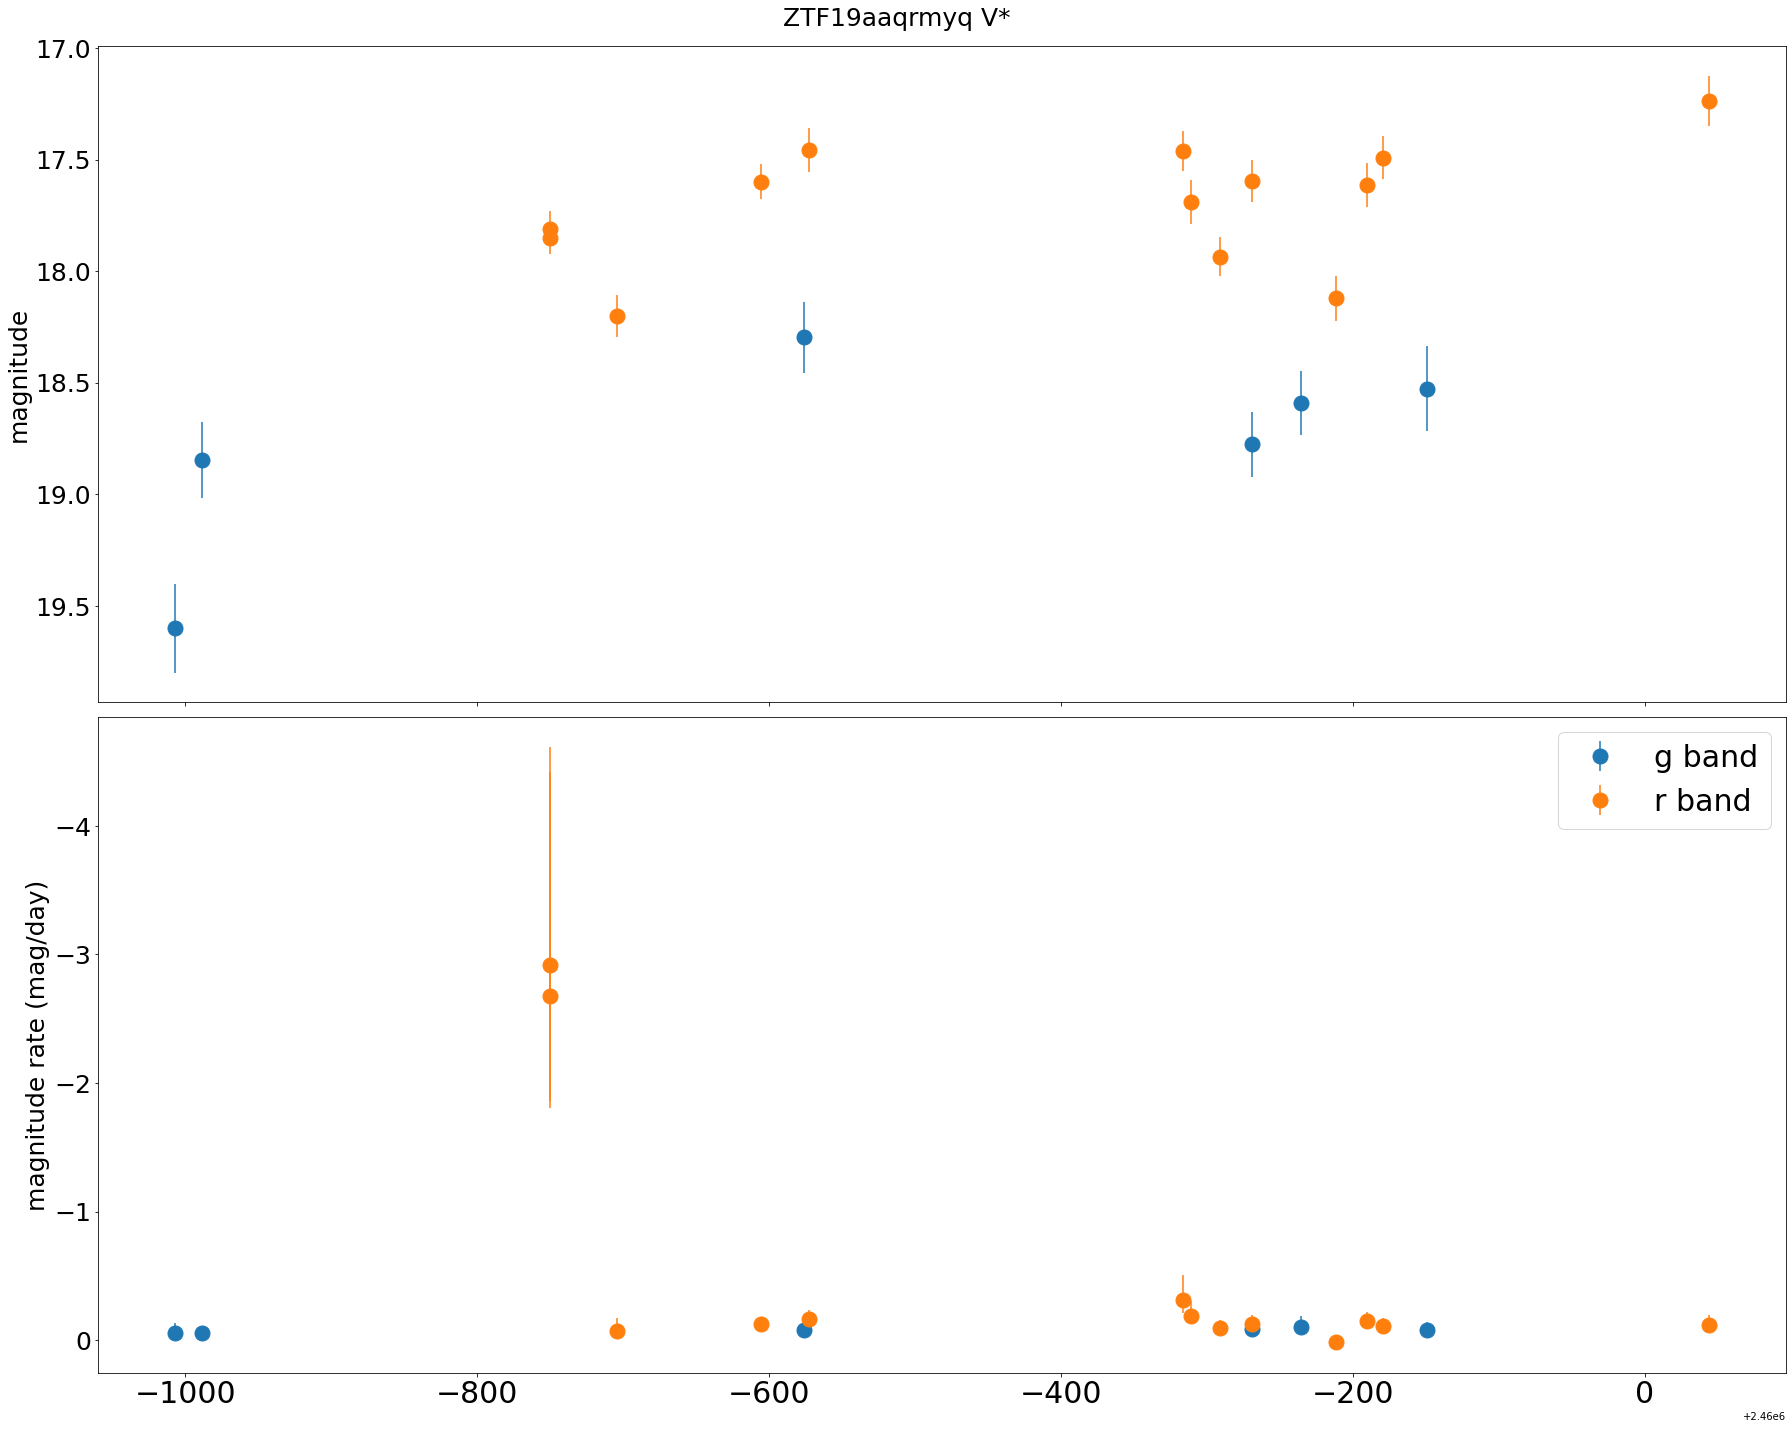

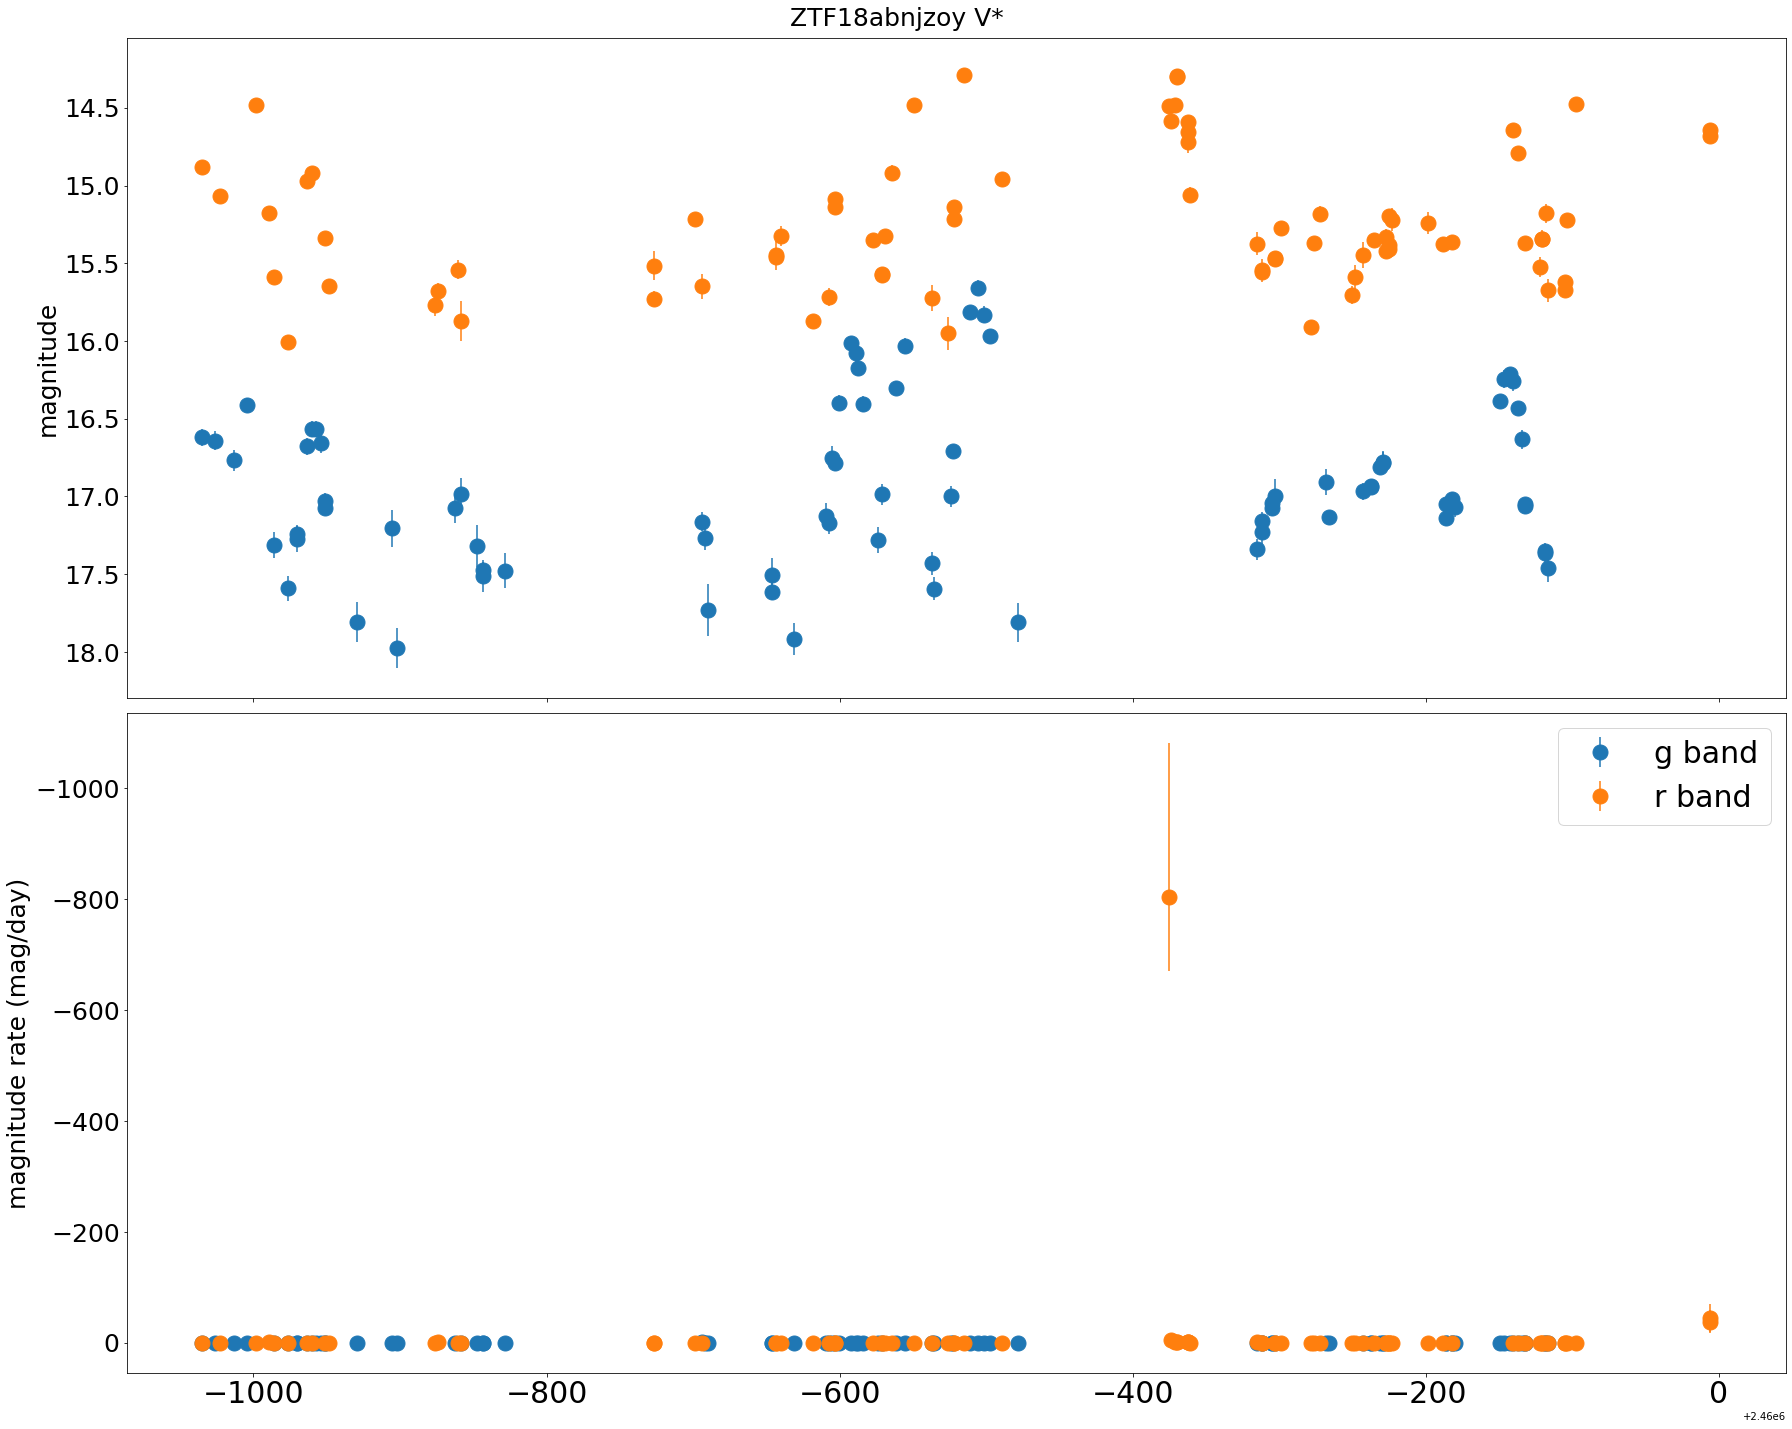

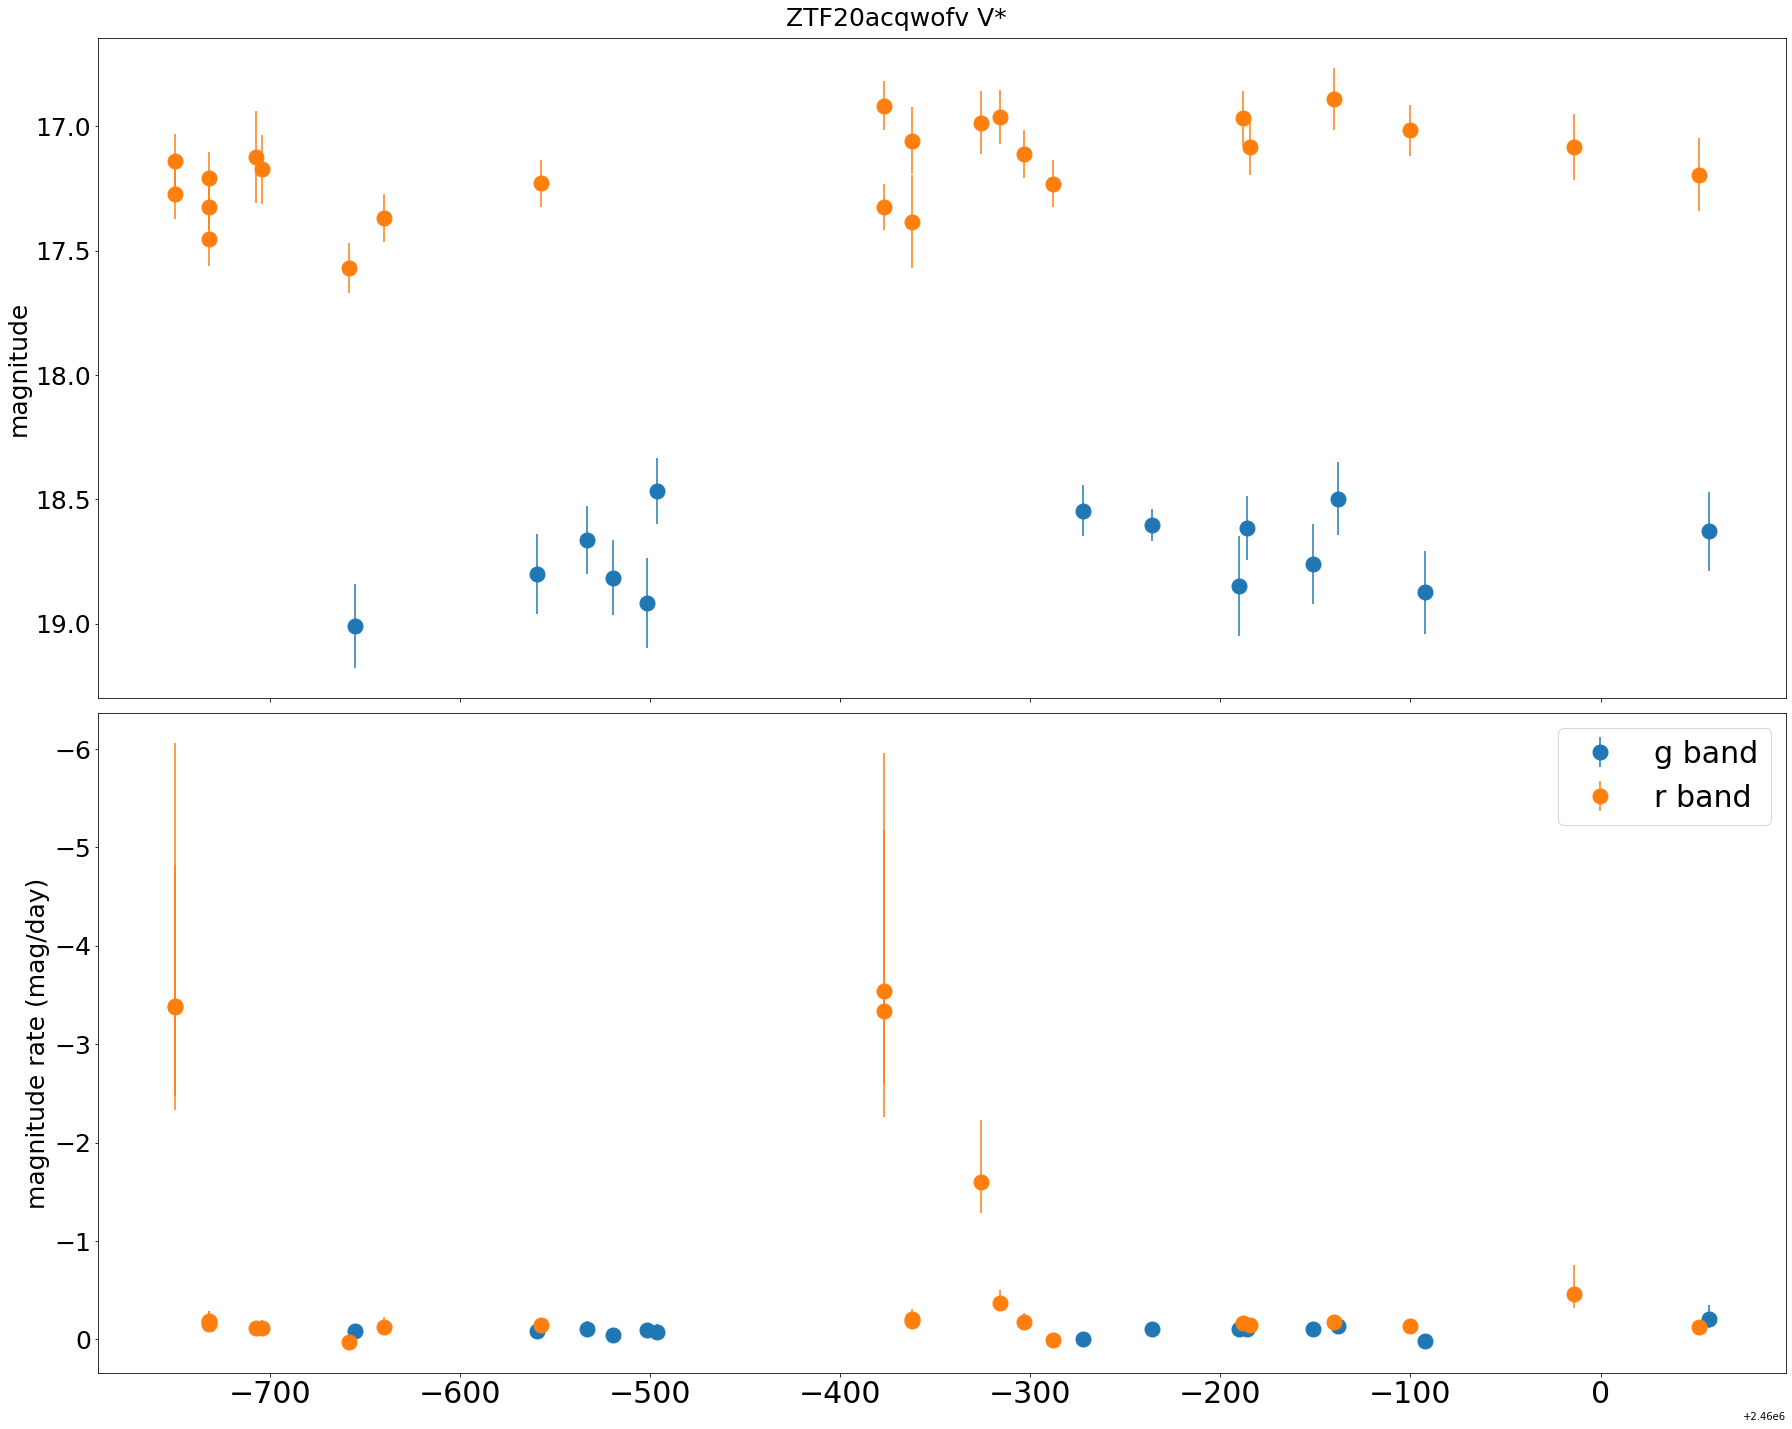

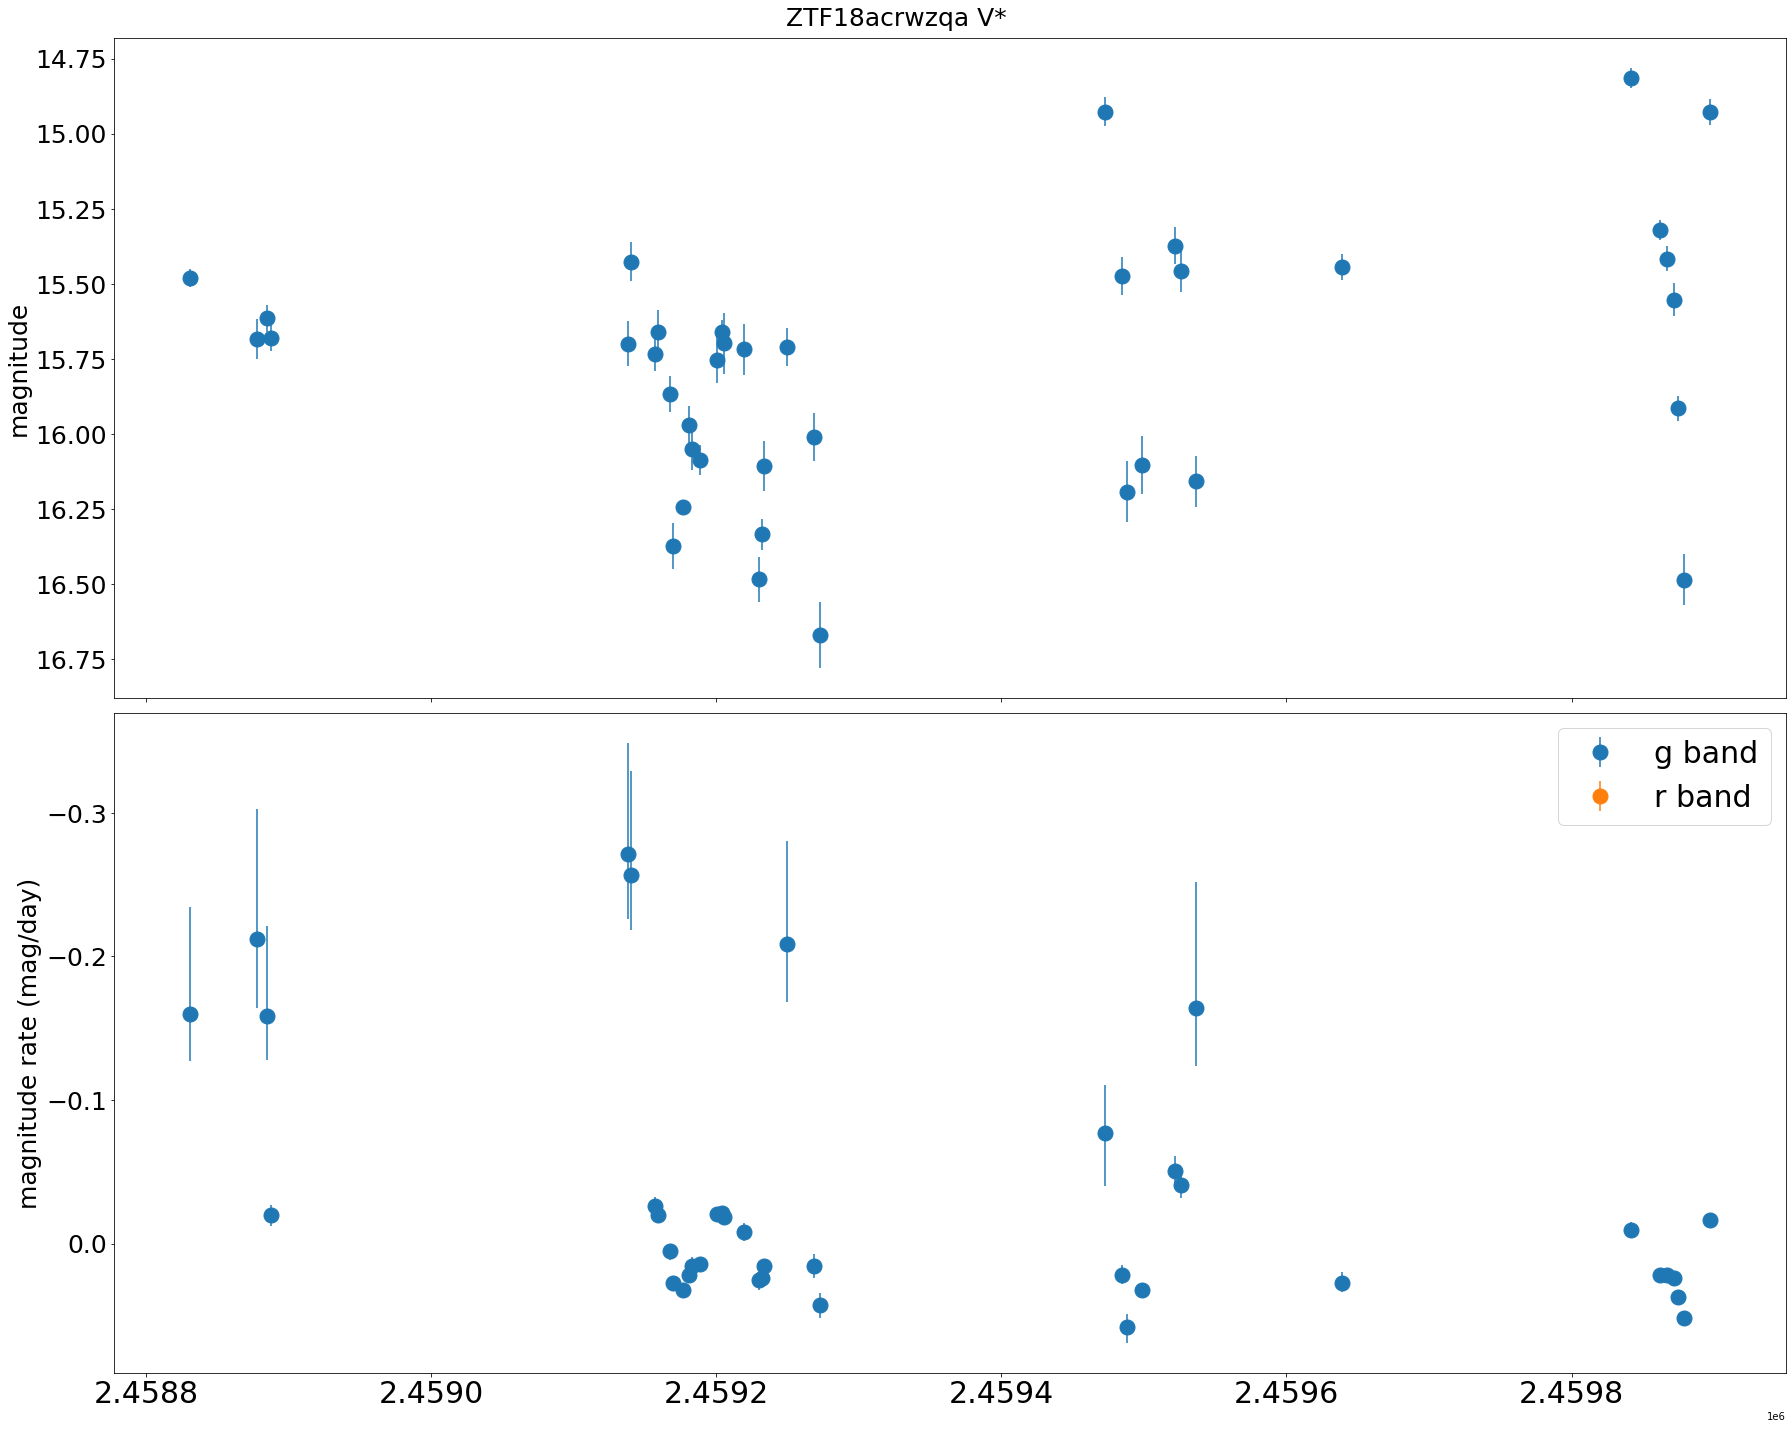

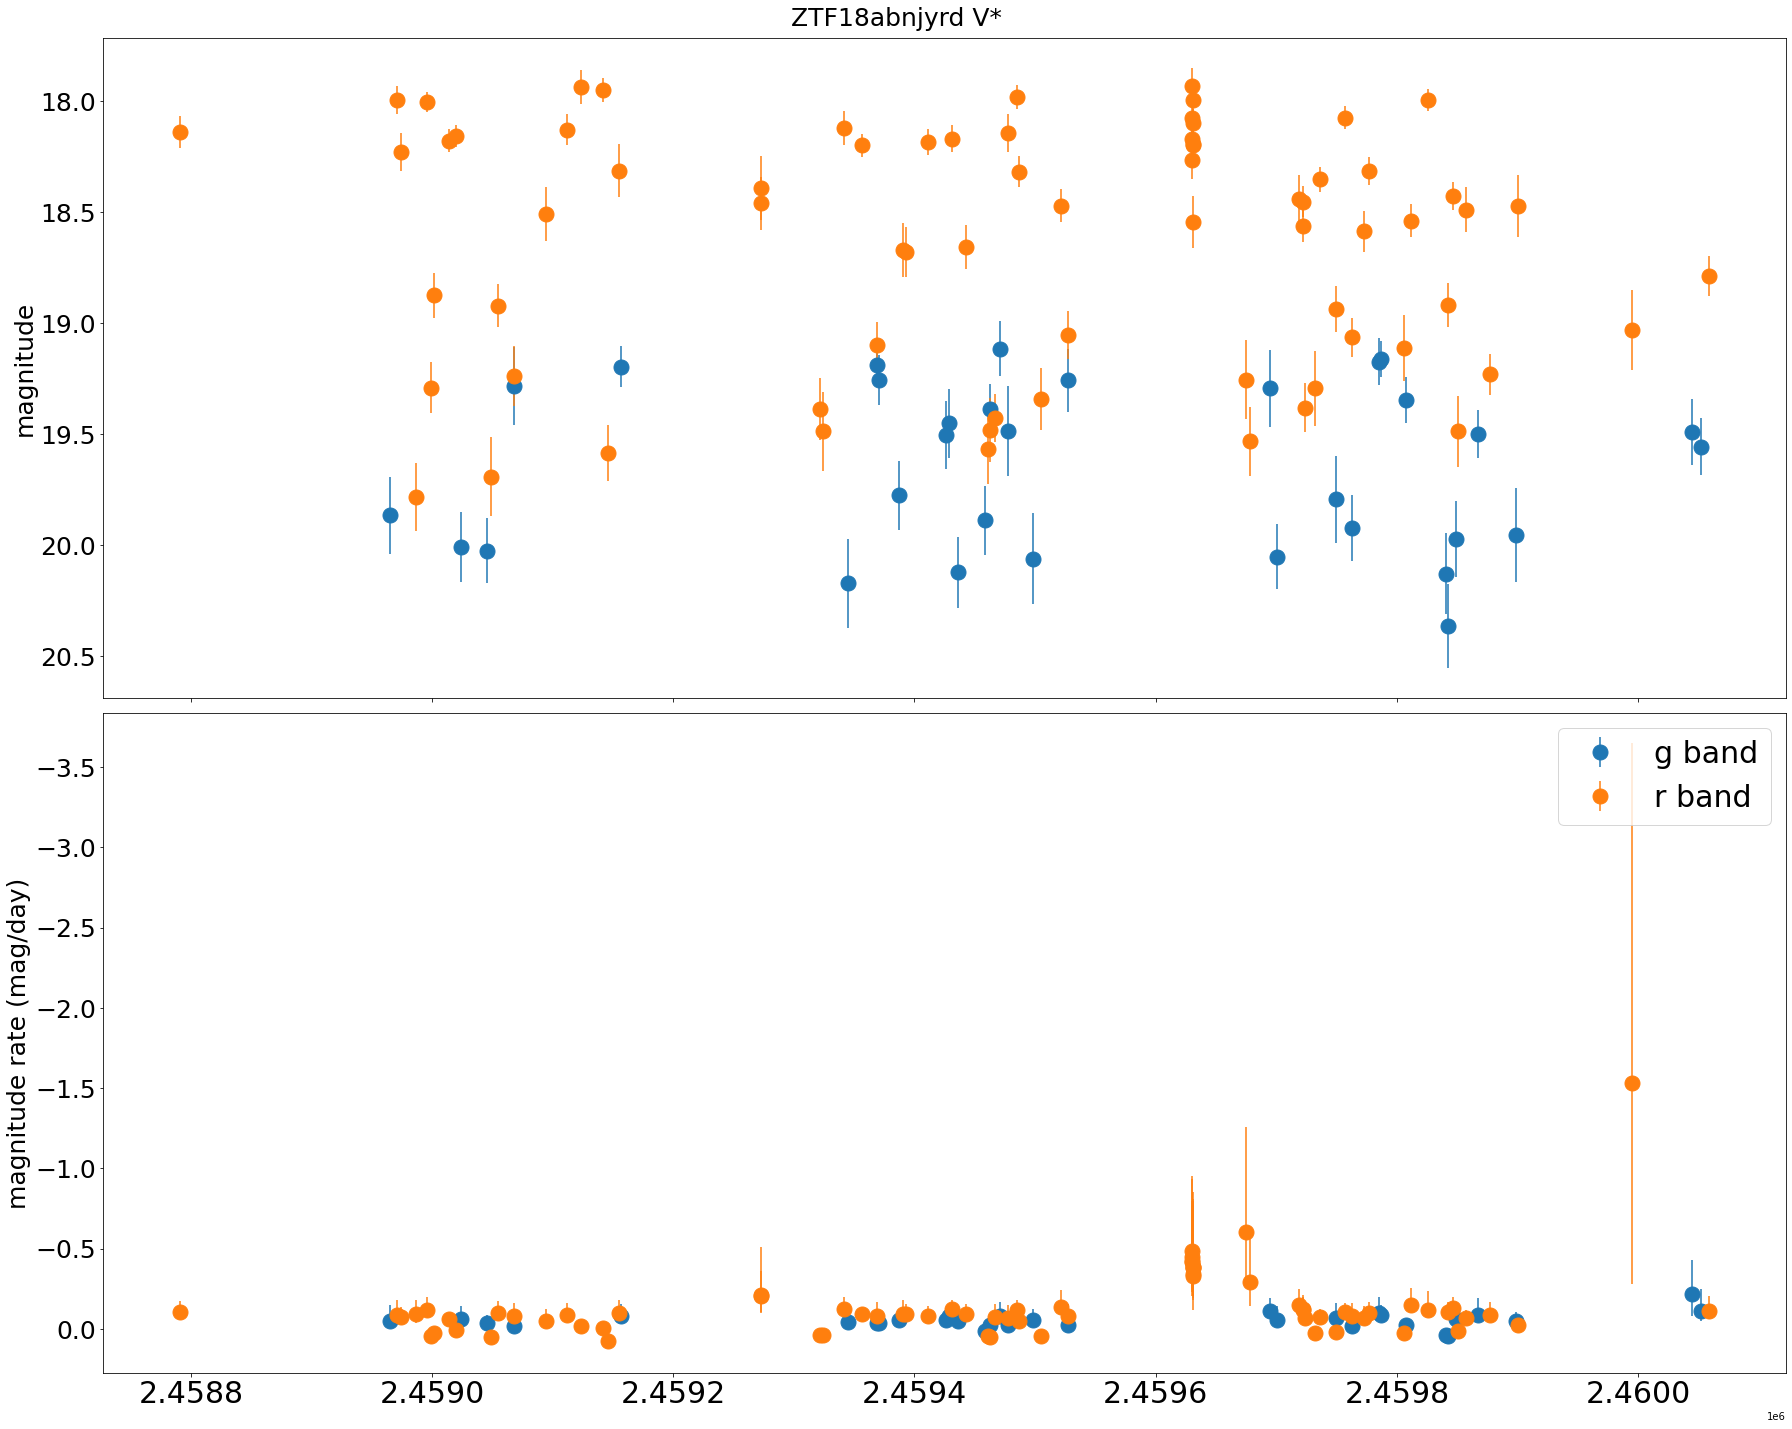

In [44]:
for objId in sample_object:
    obj_example = clean_rate[clean_rate["objectId"] == objId].sort_values("jd")
    plot_magnitude_and_rate(obj_example)

### GVOM Application

In [15]:
print(
    """
Number of alerts in fink: {:,},
Number of unique objects in fink: {:,}
""".format(df.count(), df.select("objectId").distinct().count())
)


Number of alerts in fink: 117,881,663,
Number of unique objects in fink: 30,378,451



### cut drb + galactic latitude + fink class

In [96]:
@pandas_udf(DoubleType())
def lat_gal(ra, dec):
    return pd.Series(SkyCoord(ra, dec, unit="deg").galactic.b)


@pandas_udf(DoubleType())
def lat_ecliptic(ra, dec):
    return pd.Series(
        SkyCoord(ra, dec, unit="deg").transform_to("geocentricmeanecliptic").lat
    )

In [97]:
df = df.withColumn("b_gal", lat_gal(df.ra, df.dec))
df = df.withColumn("l_ecl", lat_ecliptic(df.ra, df.dec))

In [98]:
df_cut_gvom = df.filter(
    (df.drb > 0.9)  # very confident alerts
    & (
        (df.b_gal < -10)  # extra galactic cut
        | (df.b_gal > 10)
    )
    & (df.magpsf < 16)  # bright objects
    & (F.abs(df.mag_rate) > 0.3)  # fast transient
    & (df.fink_class.isin(["Unknown", "Ambiguous", "SN candidate"]))  # class cut
    & (df.jd - df.jdstarthist < 3)  # new transient
    & (
        (df.l_ecl < -10)  # remove potential unknown asteroids
        | (df.l_ecl > 10)
    )
)

In [99]:
df_gvom_local = df_cut_gvom.toPandas()

In [100]:
df_gvom_local["night"] = df_gvom_local["jd"].astype(int)

In [101]:
print(
    """
GVOM filter
Number of alerts in fink: {:,},
Number of unique objects in fink: {:,}
Number of alerts per night: {:.1f} alerts / night
""".format(
        len(df_gvom_local),
        len(df_gvom_local["objectId"].unique()),
        df_gvom_local.groupby("night").count().mean()["objectId"],
    )
)


GVOM filter
Number of alerts in fink: 13,553,
Number of unique objects in fink: 13,082
Number of alerts per night: 38.6 alerts / night



In [102]:
df_gvom_local.sort_values("jd")

,objectId,candid,fink_class,ra,dec,magpsf,sigmapsf,diffmaglim,fid,jd,...,lower_rate,upper_rate,delta_time,from_upper,year,month,b,b_gal,l_ecl,night
6036,ZTF19acmvxdn,1035503222315010055,Unknown,141.032337,-11.266658,15.613436,0.072977,20.134113,1,2.458790e+06,...,-0.796609,-0.427328,9.984167,True,2019,11,26.766559,26.766559,-25.122744,2458790
1306,ZTF19acmxbtp,1035516871415015007,Unknown,177.408929,15.780112,14.451644,0.041271,17.797720,1,2.458790e+06,...,-2.727676,-1.366690,2.990903,True,2019,11,71.713299,71.713299,13.425430,2458790
1307,ZTF19acmwrck,1035516875915015054,Unknown,179.402477,21.540343,14.930362,0.051397,18.981668,1,2.458790e+06,...,-2.347607,-1.182383,2.990903,True,2019,11,76.536822,76.536822,19.449205,2458790
5829,ZTF19acmxefo,1035516872615015060,Unknown,179.027496,17.570659,15.889865,0.054963,19.434742,1,2.458790e+06,...,-1.722094,-0.769529,2.990903,True,2019,11,74.052637,74.052637,15.694611,2458790
1327,ZTF19acmxbtv,1035516871415010097,Unknown,177.088974,15.690470,15.922644,0.067575,17.797720,1,2.458790e+06,...,-2.374852,-0.869667,2.990903,True,2019,11,71.421508,71.421508,13.217879,2458790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,ZTF23aafwsuu,2299433873115015007,SN candidate,283.863483,81.824213,13.919687,0.017989,20.027298,2,2.460054e+06,...,-0.371745,-0.262809,23.975972,True,2023,4,26.687986,26.687986,74.383575,2460053
1459,ZTF23aagpixm,2300398365415015003,Unknown,263.584564,0.080725,13.919264,0.026141,20.157679,2,2.460055e+06,...,-0.423683,-0.283884,21.958345,True,2023,4,17.123254,17.123254,23.363764,2460054
1471,ZTF23aagsaxq,2301267081515015008,Unknown,203.984577,1.297644,14.440236,0.031135,20.255787,2,2.460056e+06,...,-0.373958,-0.261169,22.898611,True,2023,4,62.051104,62.051104,10.510226,2460055
1344,ZTF23aahbjbo,2302439141015015003,Unknown,258.057180,-12.883189,14.637235,0.030329,20.172201,1,2.460057e+06,...,-0.530563,-0.309492,14.042187,True,2023,4,15.205007,15.205007,10.066916,2460056


### Debug

In [3]:
df.agg({"nalerthist": "max"}).collect()[0]

Row(max(nalerthist)=198)

In [7]:
large_lc_id = df.filter(df.nalerthist > 150).select("objectId").distinct().toPandas()

In [14]:
large_lc = df.filter(df.objectId.isin(list(large_lc_id.objectId.values))).toPandas()

In [53]:
large_lc["fink_class"].unique()

array(['Unknown', 'LPV*', 'CV*_Candidate', 'EB*_Candidate', 'Mira',
       'RRLyr', 'BLLac', 'QSO', 'EB*', 'Star', 'Candidate_LP*',
       'Candidate_EB*', 'V*', 'Seyfert_1', 'Candidate_CV*', 'Radio',
       'LP*_Candidate', 'SN', 'MolCld', 'WD*', 'low-mass*',
       'SN candidate', 'Microlensing candidate'], dtype=object)

In [59]:
large_lc[large_lc["fink_class"] == "Seyfert_1"]

,objectId,candid,fink_class,ra,dec,magpsf,sigmapsf,diffmaglim,fid,jd,...,jd_first_real_det,jdstarthist_dt,mag_rate,sigma_rate,lower_rate,upper_rate,delta_time,from_upper,year,month
109,ZTF18aauselm,1786117031415010010,Seyfert_1,291.831507,65.565079,16.328951,0.029944,19.530504,1,2.459541e+06,...,2.459511e+06,1267.652049,0.007016,0.001561,0.004260,0.009508,29.899155,False,2021,11
115,ZTF18aauselm,1748220771415010006,Seyfert_1,291.831474,65.565078,16.325113,0.031218,19.617287,1,2.459503e+06,...,2.459474e+06,1230.750590,0.014764,0.001564,0.012121,0.017224,28.849456,False,2021,10
125,ZTF18aauselm,1748191556115010002,Seyfert_1,291.831428,65.565070,15.918632,0.044043,19.767838,2,2.459503e+06,...,2.459474e+06,1230.750590,0.010226,0.002134,0.007415,0.013583,28.952141,False,2021,10
140,ZTF18aauselm,1413217741415010015,Seyfert_1,291.831517,65.565075,16.338615,0.037648,19.755213,2,2.459168e+06,...,2.459138e+06,894.733368,0.025923,0.001848,0.022878,0.029050,27.979213,False,2020,11
165,ZTF18aauselm,1775220851415010009,Seyfert_1,291.831461,65.565086,16.320475,0.037441,19.823141,1,2.459530e+06,...,2.459503e+06,1259.648044,0.014764,0.001659,0.012279,0.017680,27.083993,False,2021,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27775,ZTF18aauselm,1581451856115010000,Seyfert_1,291.831414,65.565087,16.118525,0.034950,19.732033,1,2.459336e+06,...,2.459307e+06,1063.943993,-0.007891,0.001784,-0.010990,-0.004891,29.019039,False,2021,5
27777,ZTF18aauselm,1287278866115010003,Seyfert_1,291.831393,65.565110,15.941357,0.051690,20.455849,2,2.459042e+06,...,2.459012e+06,768.822627,0.010716,0.002035,0.007758,0.014061,29.947349,False,2020,7
27778,ZTF18aauselm,1161469251415010023,Seyfert_1,291.831436,65.565079,16.421864,0.028015,18.969128,1,2.458916e+06,...,2.458889e+06,646.026794,0.019804,0.001889,0.016629,0.022536,22.912002,False,2020,3
27854,ZTF18aauselm,1616455791415010013,Seyfert_1,291.831380,65.565097,16.341091,0.050912,20.526621,2,2.459371e+06,...,2.459342e+06,1098.876134,0.025360,0.001874,0.022386,0.028624,29.002859,False,2021,6


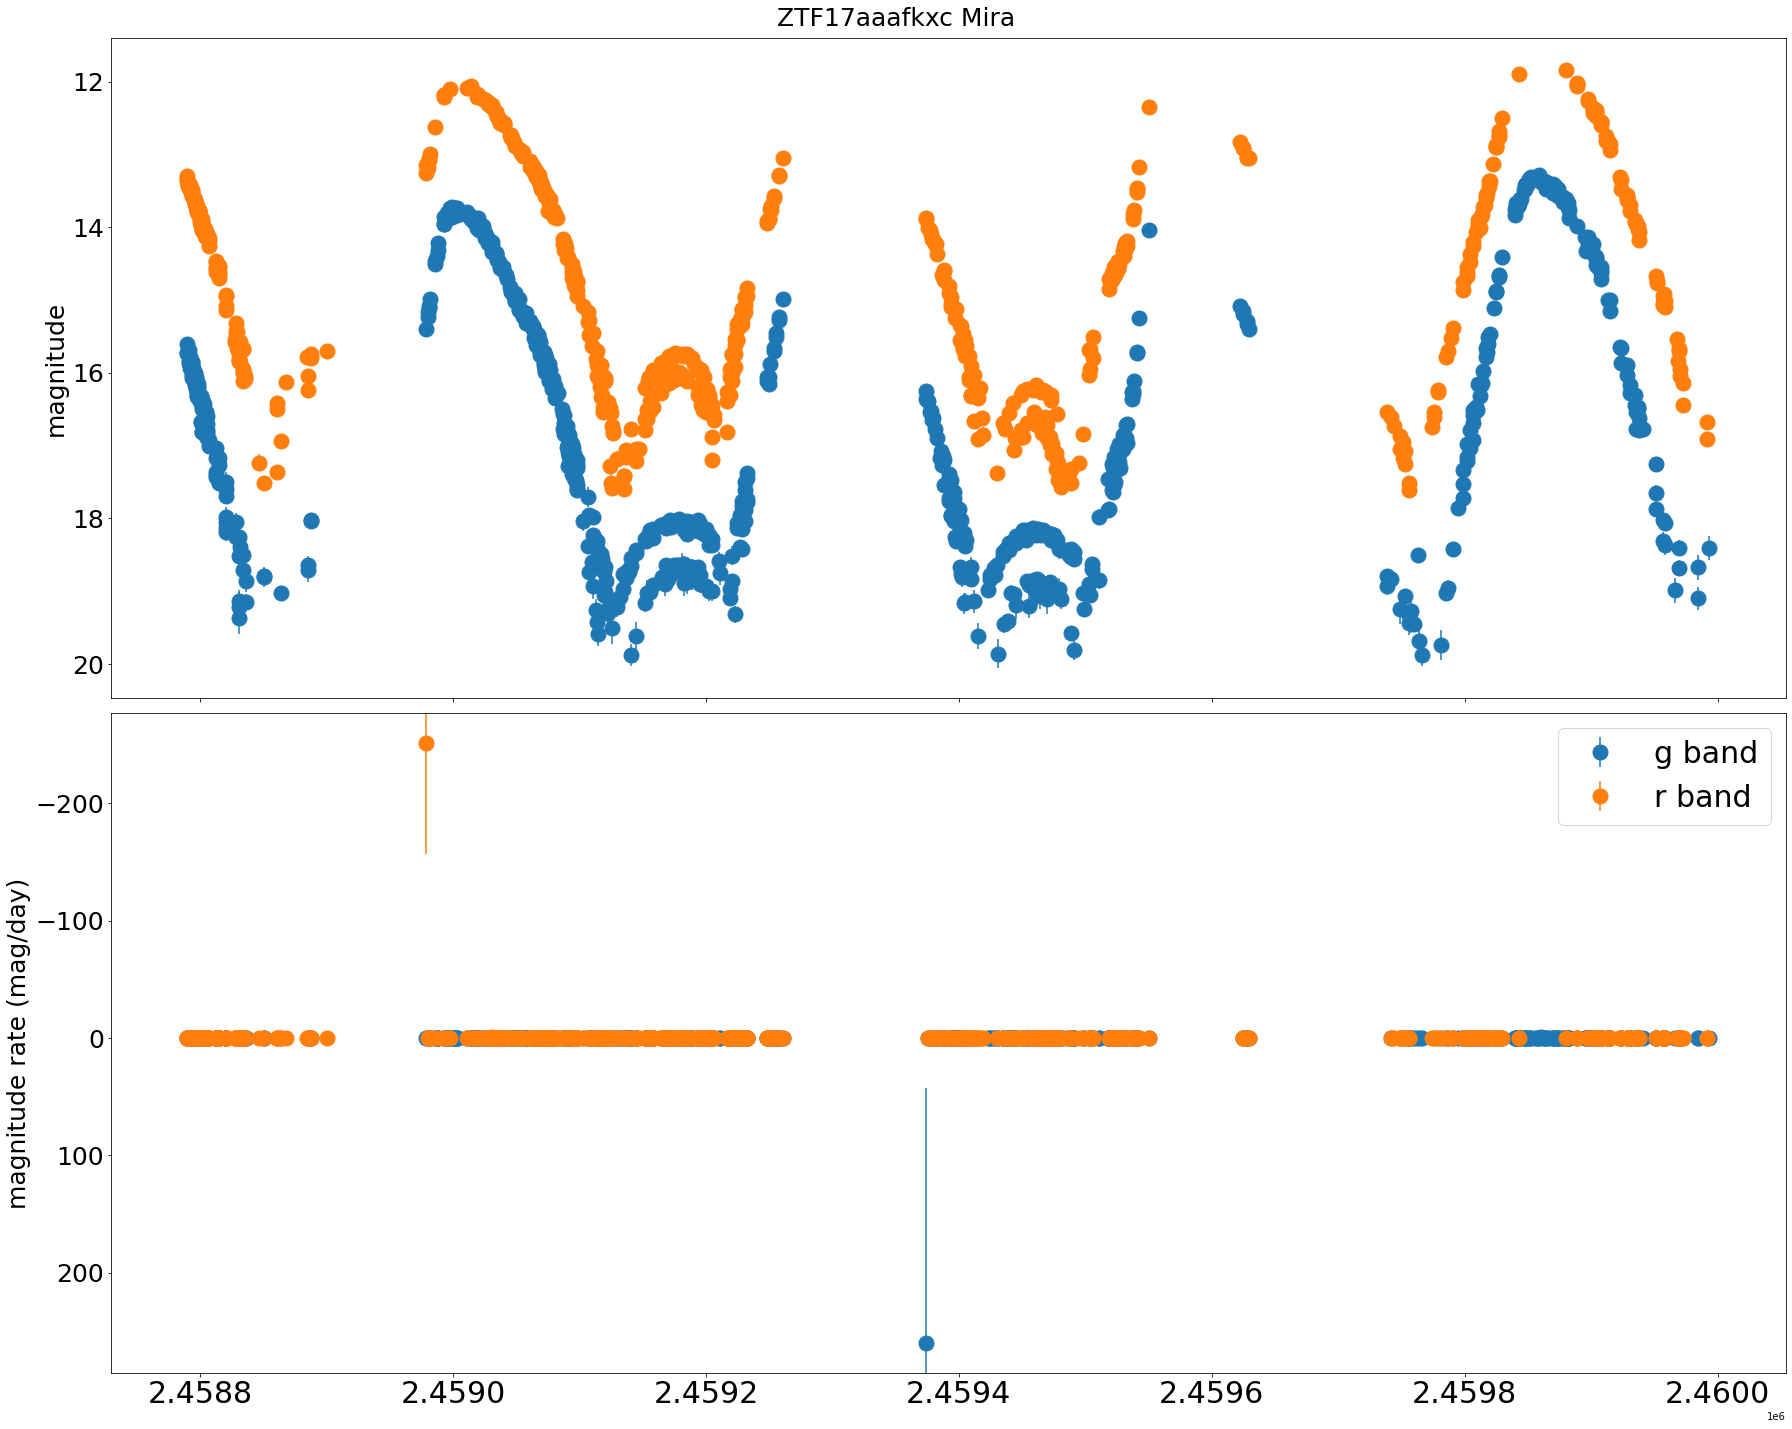

In [27]:
plot_magnitude_and_rate(large_lc[large_lc["objectId"] == "ZTF17aaafkxc"])

In [37]:
data = large_lc[large_lc["objectId"] == "ZTF17aaafkxc"].sort_values("jd")

In [43]:
data[["mag_rate", "magpsf", "jd"]]

,mag_rate,magpsf,jd
2234,0.034448,13.346504,2.458790e+06
14348,0.032246,13.343421,2.458790e+06
14346,0.030673,13.300246,2.458790e+06
13487,0.048316,15.725523,2.458790e+06
14259,0.048595,15.728276,2.458790e+06
...,...,...,...
1606,0.038415,19.100367,2.459985e+06
1591,0.024754,18.675932,2.459985e+06
1862,-0.155404,16.675854,2.459992e+06
9270,0.056841,16.906393,2.459992e+06


In [46]:
diff_rate = np.diff(data["magpsf"]) / np.diff(data["jd"])

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


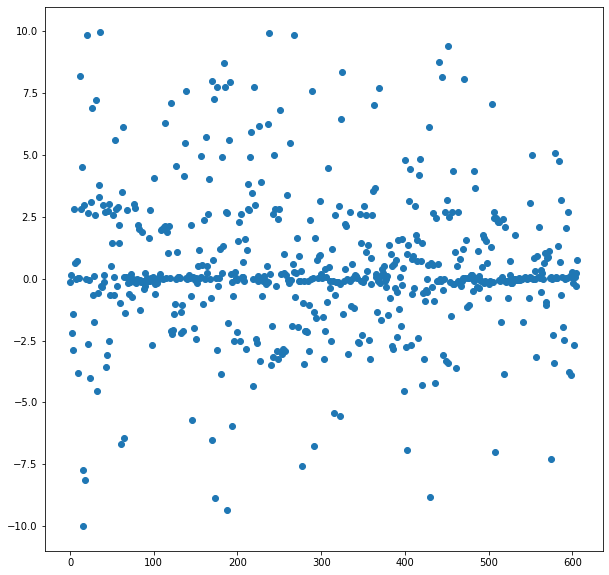

In [50]:
plt.figure(figsize=(10, 10))
diff_rate_sub = diff_rate[(diff_rate > -10) & (diff_rate < 10)]
plt.scatter(np.arange(len(diff_rate_sub)), diff_rate_sub)
plt.show()

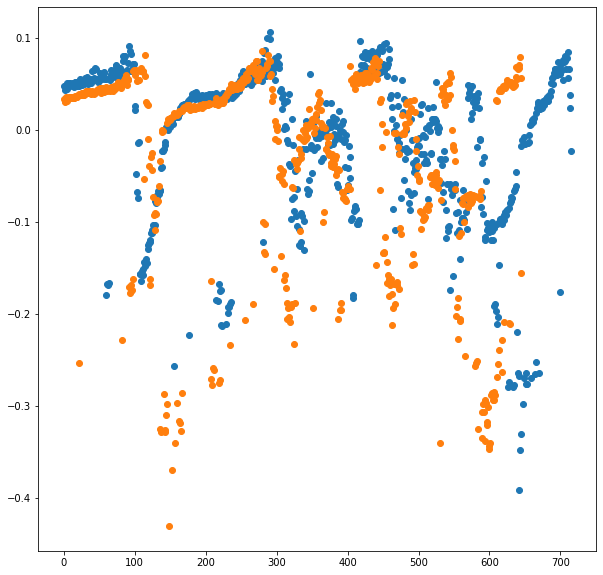

In [52]:
plt.figure(figsize=(10, 10))
data_rate = data[(data["mag_rate"] > -10) & (data["mag_rate"] < 10)]
data_rate_fid_1 = data_rate[data_rate["fid"] == 1]["mag_rate"]
data_rate_fid_2 = data_rate[data_rate["fid"] == 2]["mag_rate"]
plt.scatter(np.arange(len(data_rate_fid_1)), data_rate_fid_1)
plt.scatter(np.arange(len(data_rate_fid_2)), data_rate_fid_2)
plt.show()

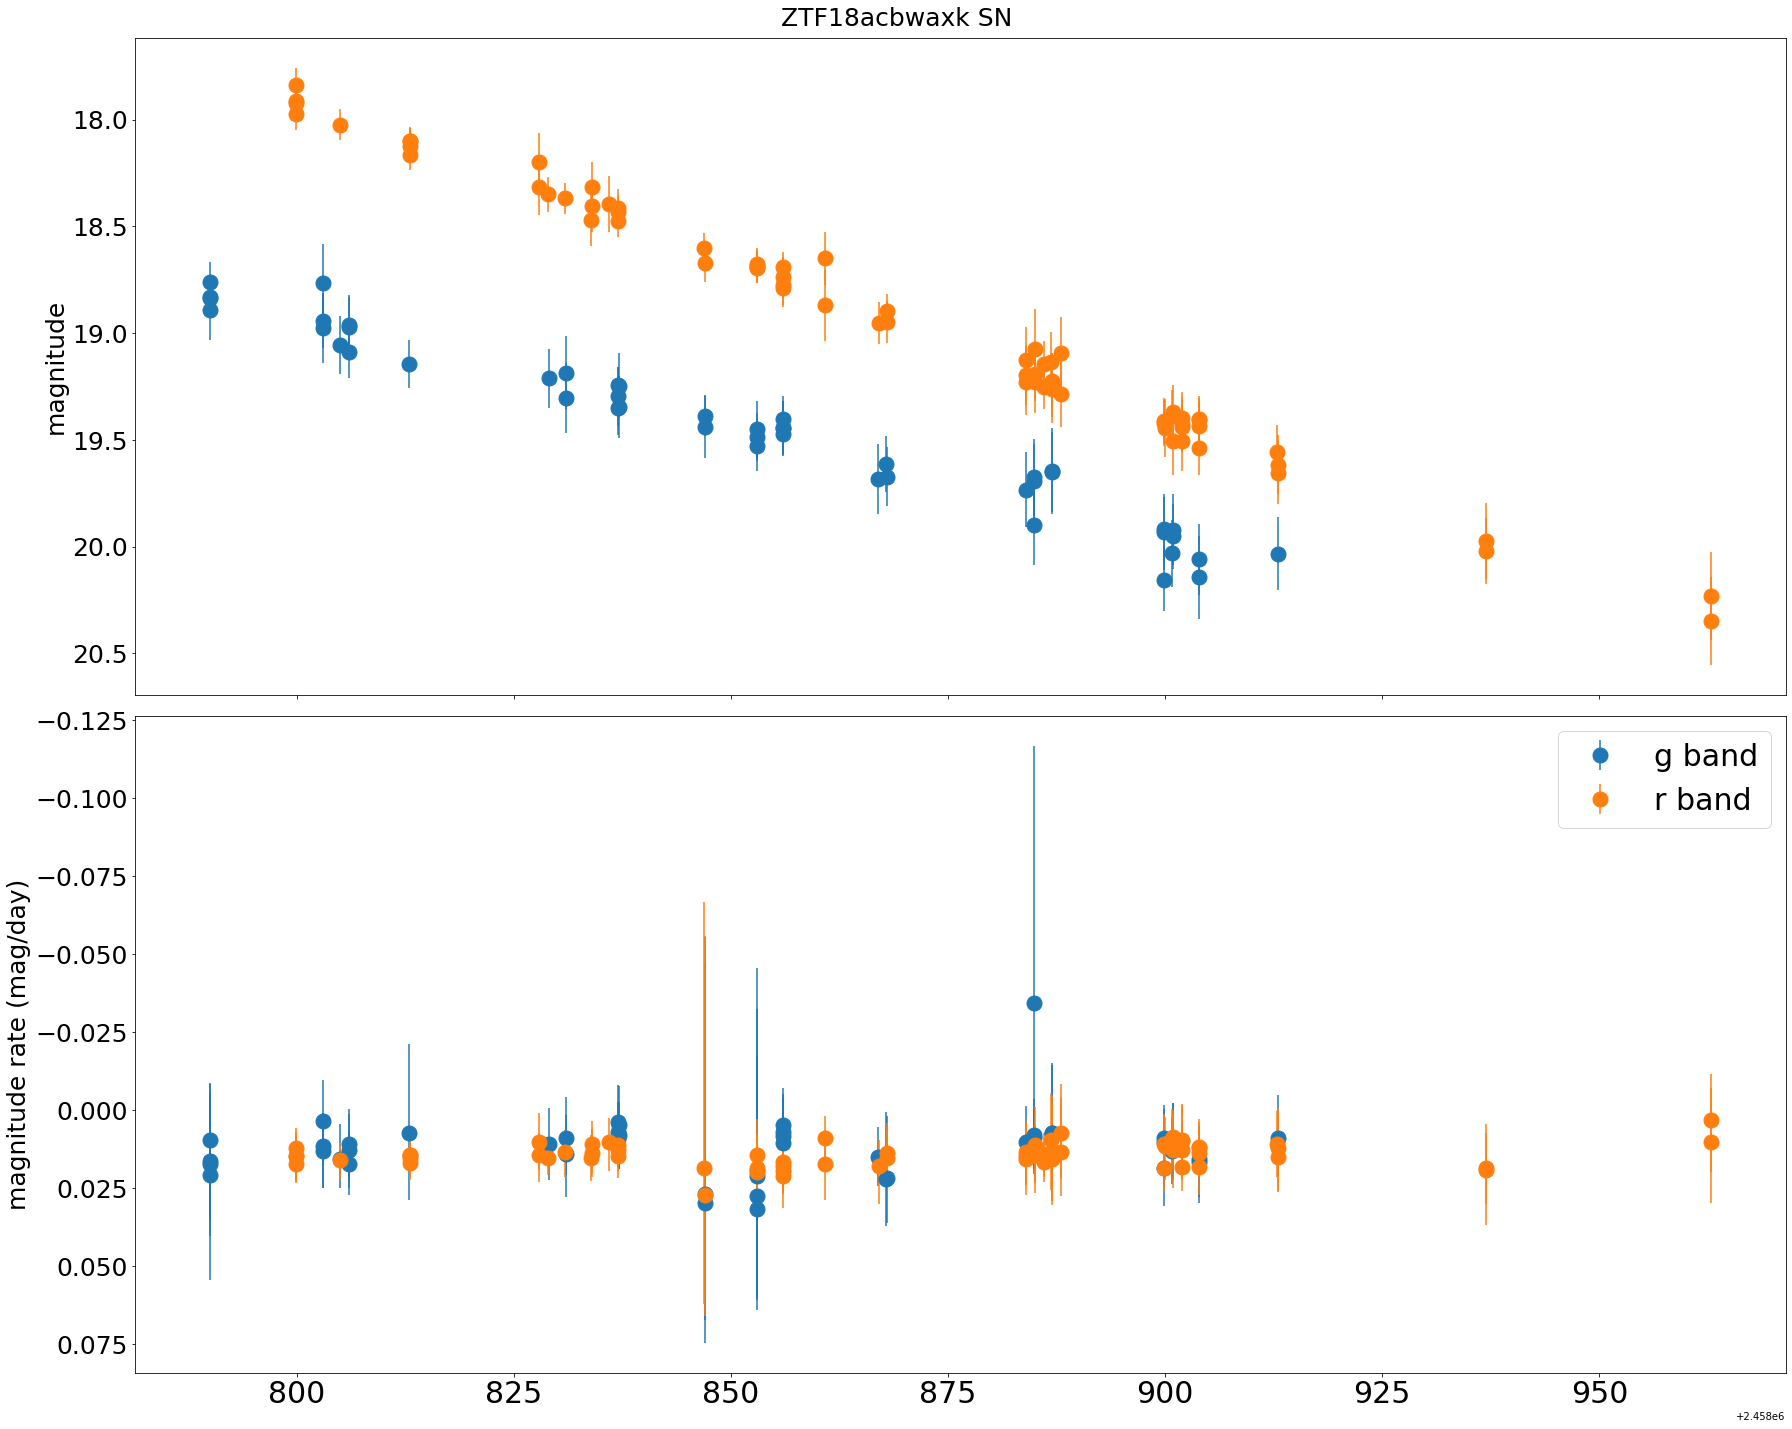

In [58]:
plot_magnitude_and_rate(large_lc[large_lc["objectId"] == "ZTF18acbwaxk"])

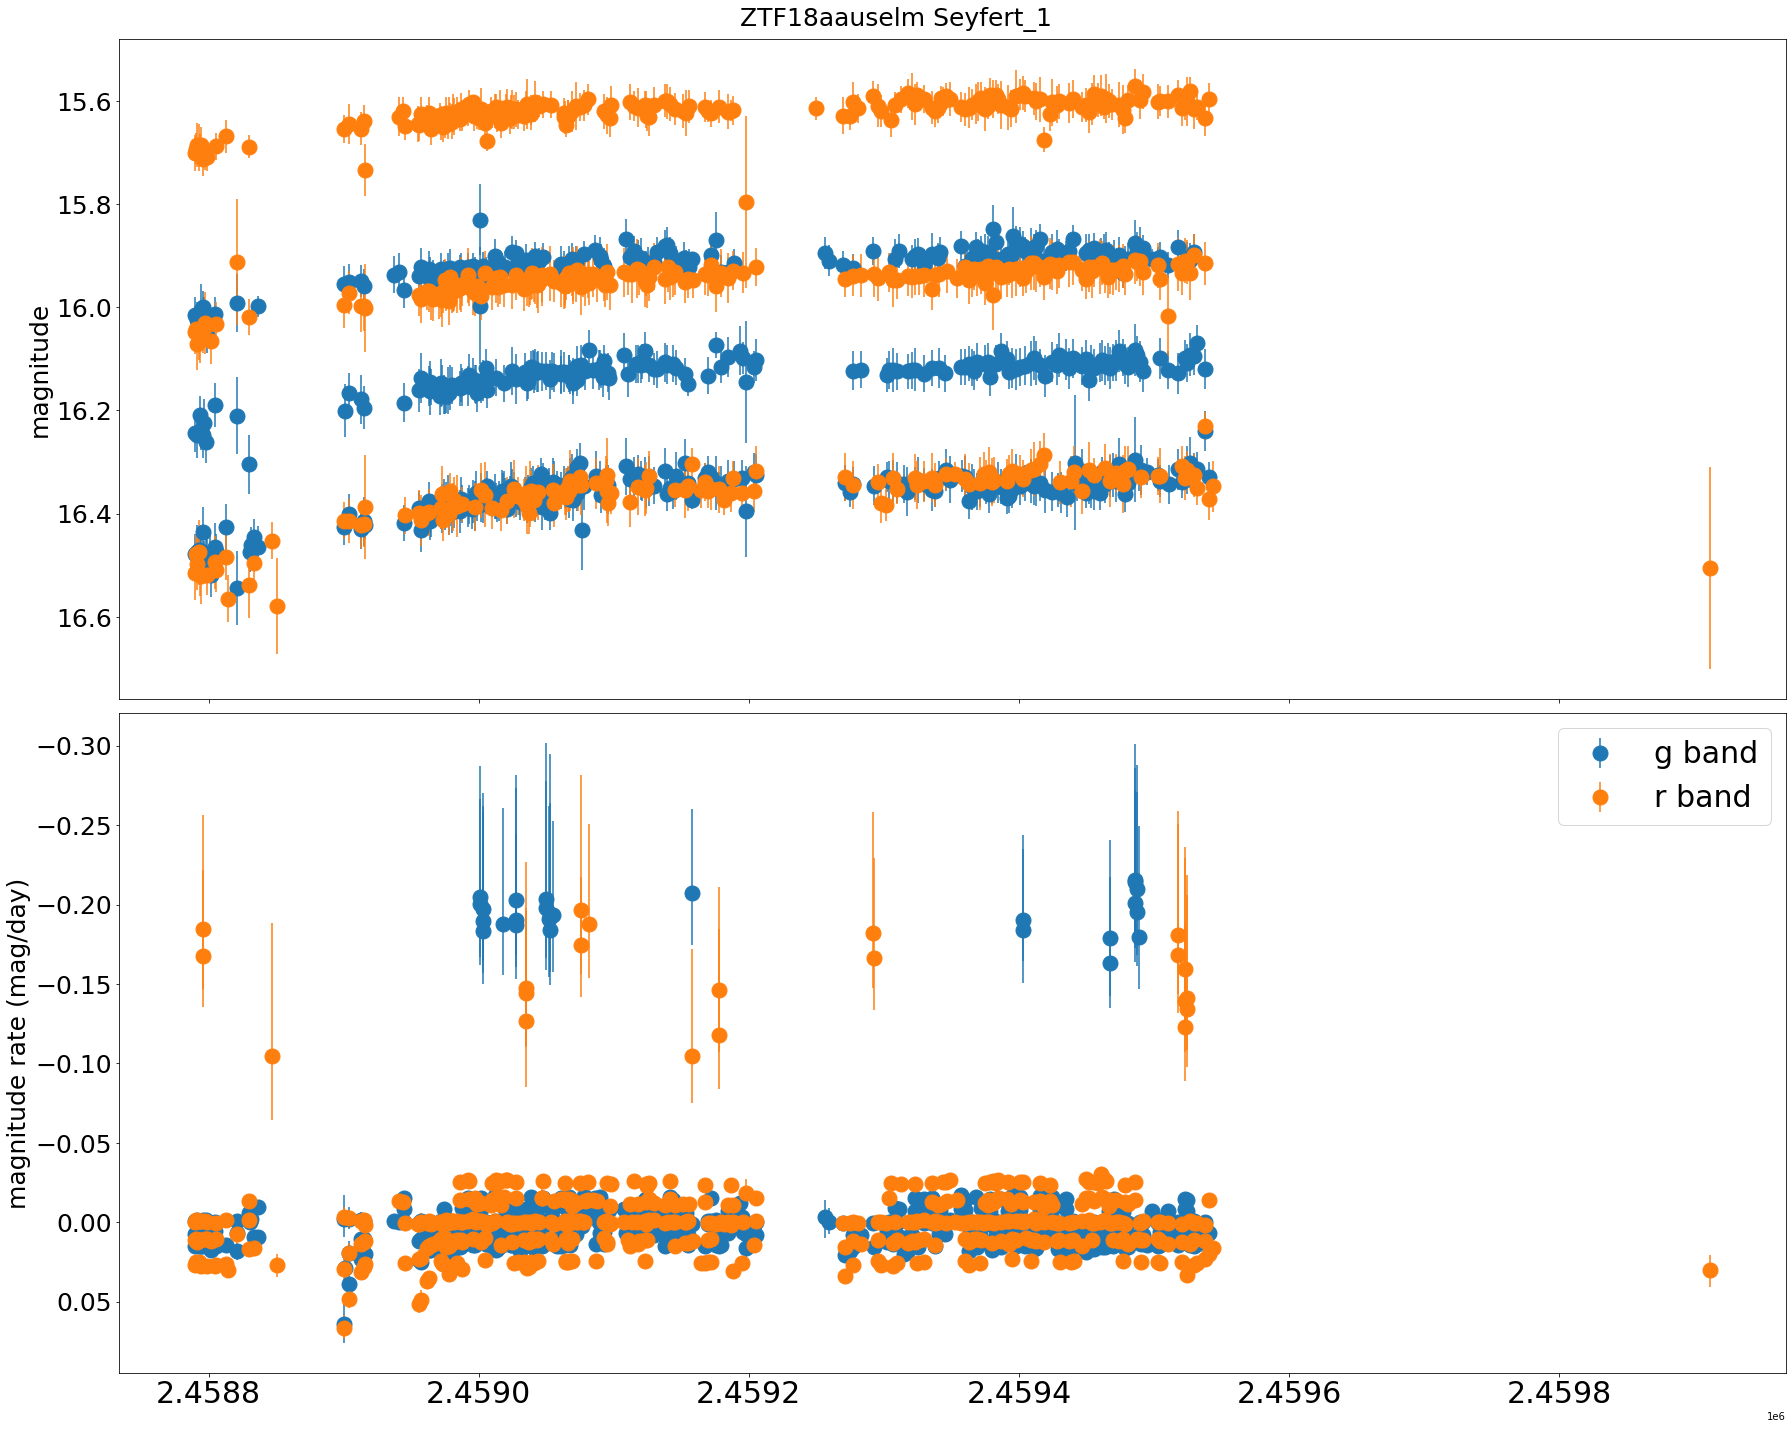

In [61]:
plot_magnitude_and_rate(large_lc[large_lc["objectId"] == "ZTF18aauselm"])